In [ ]:
!git clone https://github.com/Im-JihyunKim/2024_LG_ES_RNN  # colab 사용 시

In [ ]:
# Colab 사용 시 실행
# Local PC로 실습하는 경우에는 실행 X, 단 작업경로를 2024_LG_ES_RNN으로 맞춰주기
%cd /content/2024_LG_ES_RNN

In [1]:
# !pip install IPython
from IPython.display import Image

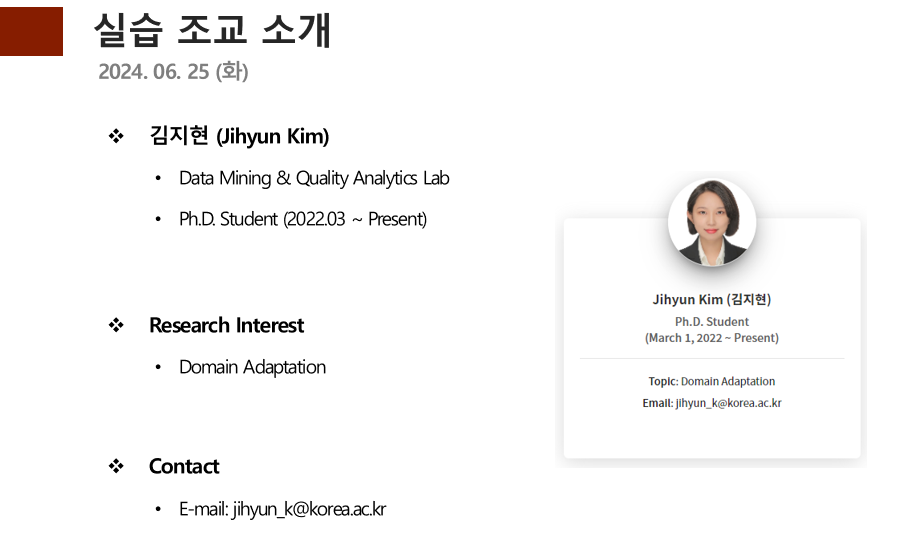

In [2]:
Image('./images/img1.PNG')

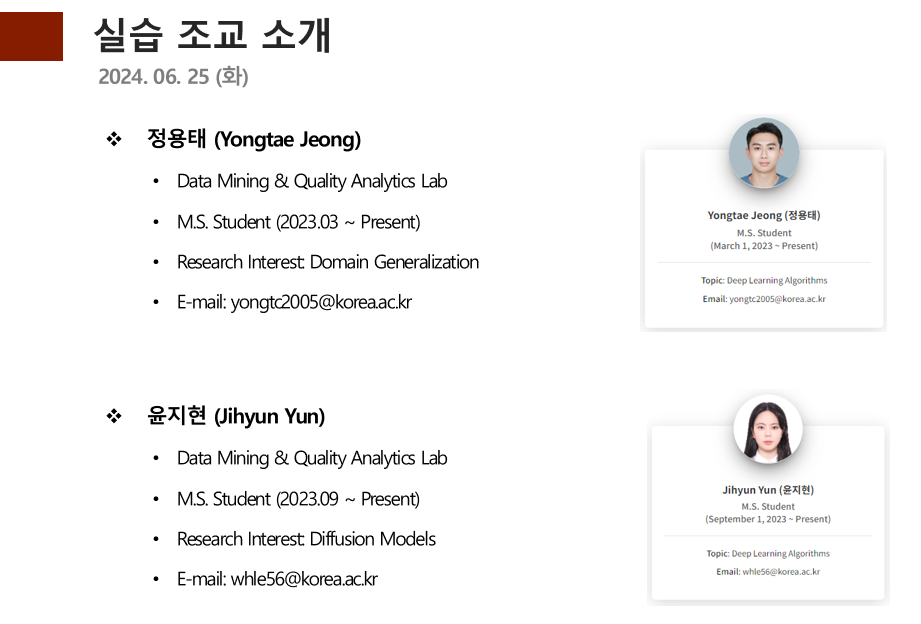

In [3]:
Image('./images/img2.PNG')

------

# Task: Time Series Classification with RNN, LSTM, and GRU with(out) Attention

#### Jupyter Notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

## 1. 필요 모듈(라이브러리) 호출

In [2]:
''' 데이터 처리를 위한 기본 모듈 및 시각화 모듈'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, time, random

'''RNN 기반 데이터 분석을 위한 딥러닝 모듈'''
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

''' 결과 평가용 모듈 '''
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings(action='ignore') 

## 2. 학습 전 준비

### GPU 확인 및 사용할 device 설정

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Seed/Random state 고정

In [3]:
# 똑같은 결과를 얻기 위한 시드 고정
def set_seed(seed:int=0):
    torch.manual_seed(seed) # torch cpu seed 고정
    torch.cuda.manual_seed(seed) # torch gpu seed 고정
    torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed) # numpy seed 고정
    random.seed(seed)    # python seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed)

## Task 수행을 위해 필요한 환경설정 (Configurations)
- 데이터 로드 - 모델 정의 - 모델 학습 알고리즘 정의 - 모델 평가 전반에 필요한 인자들
- 즉, Task 수행을 위한 하이퍼파라미터를 사전에 정의

In [4]:
# 본 튜토리얼에서는 Python의 Dictionary 형태로 정의 ('Key': value)
# .py 파일을 이용한 모델링을 수행하는 경우, argparser 이용 (https://wikidocs.net/73785 참고)

configs = {
    ### 0. 기본 설정 ###
        # device 설정
        # seed (정수 형태)

    ### 1. Data 관련 하이퍼파라미터 ###
        # 데이터가 있는 폴더 (data_dir)
        # Train, Valid, Test는 어느 비율로 나눌 것인지 (train_ratio, valid_ratio, ...)
        # Batch size는 얼마나 할지 (batch_size)
        # 데이터에 대한 augmentation 인자 (aug_prob, jitter, scale, ...)
    
    ### 2. Model 관련 하이퍼파라미터 ###
        # RNN 계열의 모델 중 무엇을 사용할 지 (RNN, LSTM, GRU, ...)
        # 모델의 차원 (hidden_dim)
        # 모델 층은 얼마나 쌓을 것인지 (num_layers)
        # RNN 계열 모델의 경우 양방향성을 가질 것인지 (bidirectional)
        # 과적합 (overfitting) 방지를 위한 여러 기법들 (dropout_rate, ...)

    ### 3. Model Training 관련 하이퍼파라미터 ###
        # 어떤 optimizer를 사용할지 (optimizer)
        # 학습율은 어느 정도로 할 지 (learning_rate/lr)
        # 최적화와 관하여 규제 여부 (momentum, weight_decay, ...)
        # 학습을 몇 번 반복할 지 (num_epochs)
        # 학습이 완료된 후 모델 파라미터를 어디에 저장할 지 (save_dir)
}
configs

{}

In [5]:
basic_configs = {'device': 'cuda' if torch.cuda.is_available() else 'cpu',
                 'seed': 0}

configs.update(basic_configs)   # 기존에 정의했던 configs 빈 껍데기에 basic_configs 값을 추가
configs

{'device': 'cuda', 'seed': 0}

## 3. Dataset 및 Dataloader 정의

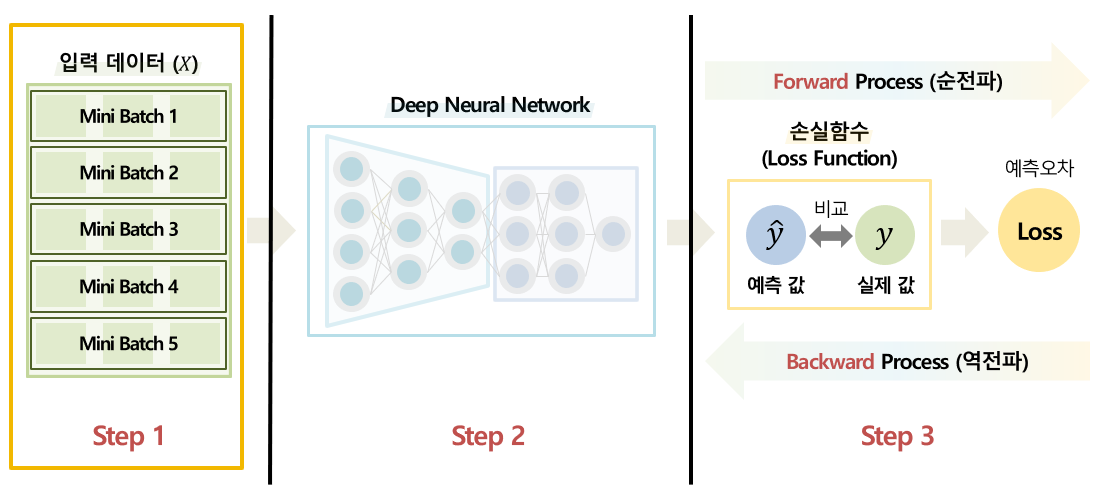

In [22]:
Image('./images/dataset.PNG')

### 실습 데이터셋: [Human Activity Recognition (HAR) Dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)
- 30명의 피실험자들이 각자 스마트폰을 허리에 착용하고 6가지 활동 (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying)을 수행할 때 측정된 센서 값으로 구성된 데이터셋
- 누락된 결측 값에 대해 정제된 데이터

<br/>

- 입력 변수(X) : 9종류의 센서 데이터 (각 센서는 50Hz 단위로 샘플링됨)
    - 2.56초만큼 데이터를 잘라내서 하나의 샘플로 사용해야 함 (Sliding Window)
- 출력 변수(Y) : 6종류의 Activity Type (Class 개수는 6개)

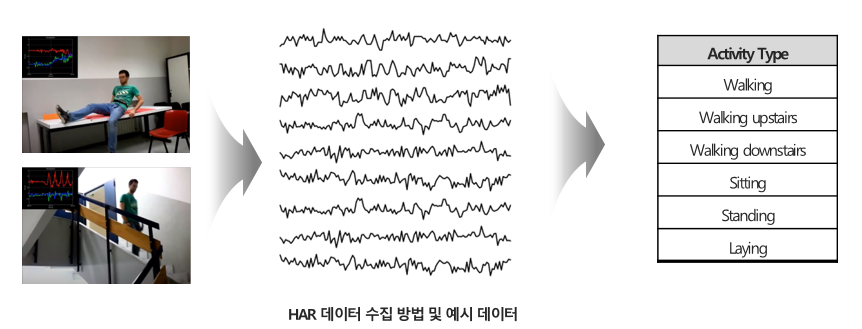

In [7]:
Image('./images/HAR1.PNG')

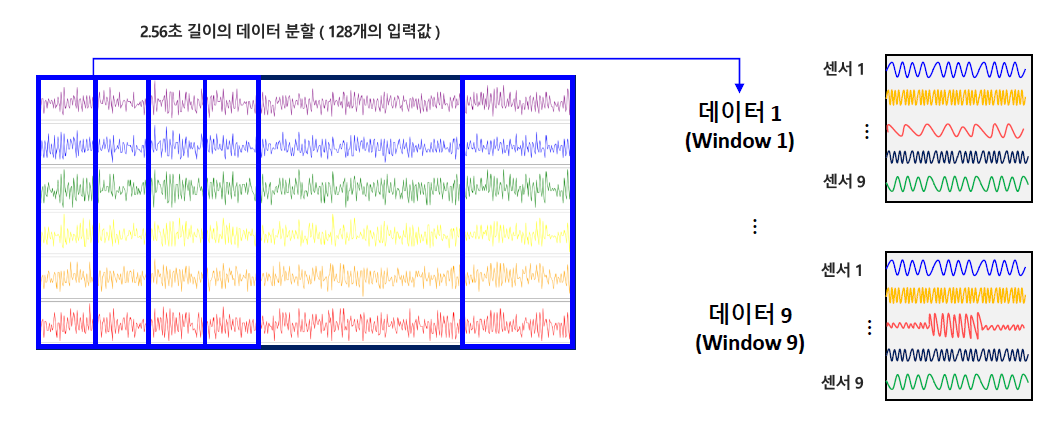

In [8]:
Image('./images/HAR2.PNG')

- 50Hz로 샘플링 (1초에 50개의 센서 값이 수집) 된 데이터셋
- 2.56초 (2.56*50=128개의 센서 값) 마다 잘라서 데이터를 하나씩 만들어냄

### 3-1. 데이터셋 불러오기

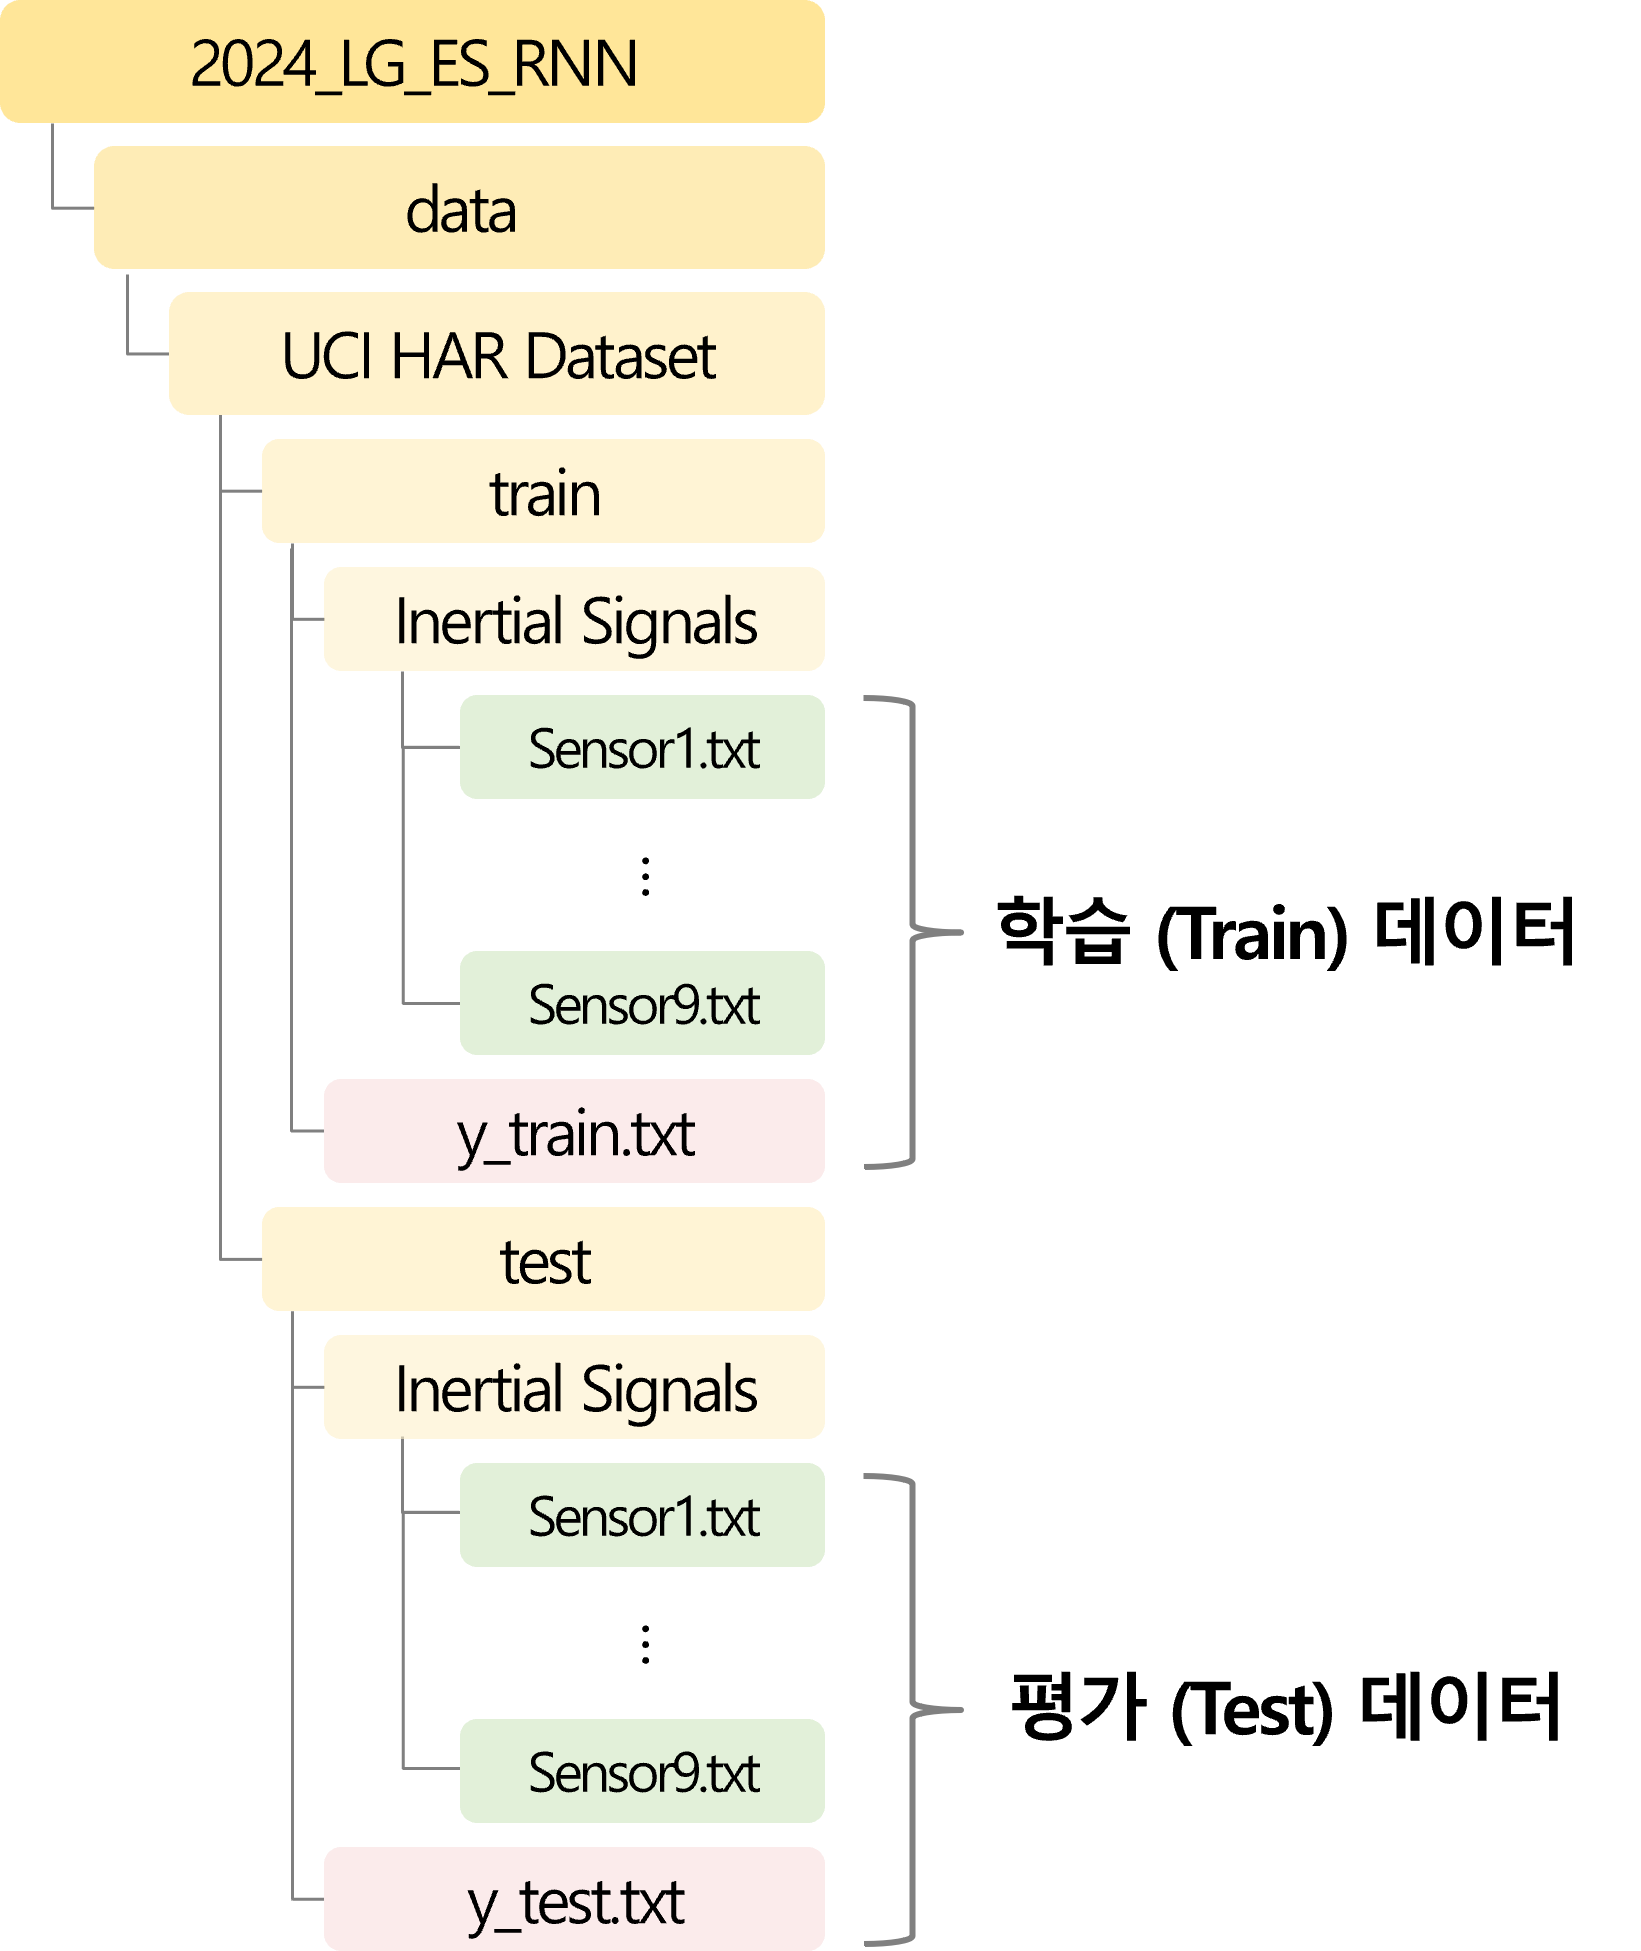

In [4]:
Image('./images/HAR3.PNG', width=500, height=600)

In [6]:
# 1. 데이터셋이 담긴 상위 폴더
data_dir = './data/UCI HAR Dataset/'

# 2. 상위 폴더 (data_dir) 내의 train/test 데이터 경로 정의 -> 입력 데이터 (X)를 불러오는 과정
    ## 본인이 프로젝트에 사용할 데이터셋이 train/test가 구분된 형태가 아니라면 생략 ##
train_path = glob.glob(os.path.join(data_dir, 'train/Inertial Signals/*'))
test_path = glob.glob(os.path.join(data_dir, 'test/Inertial Signals/*'))
print(train_path, '\n', '입력 데이터 (X)의 센서 개수:', len(train_path))

['./data/UCI HAR Dataset/train/Inertial Signals\\body_acc_x_train.txt', './data/UCI HAR Dataset/train/Inertial Signals\\body_acc_y_train.txt', './data/UCI HAR Dataset/train/Inertial Signals\\body_acc_z_train.txt', './data/UCI HAR Dataset/train/Inertial Signals\\body_gyro_x_train.txt', './data/UCI HAR Dataset/train/Inertial Signals\\body_gyro_y_train.txt', './data/UCI HAR Dataset/train/Inertial Signals\\body_gyro_z_train.txt', './data/UCI HAR Dataset/train/Inertial Signals\\total_acc_x_train.txt', './data/UCI HAR Dataset/train/Inertial Signals\\total_acc_y_train.txt', './data/UCI HAR Dataset/train/Inertial Signals\\total_acc_z_train.txt'] 
 입력 데이터 (X)의 센서 개수: 9


- 데이터 파일의 확장자는 .txt

In [7]:
# 3. 하나의 .txt 파일을 line 별로 읽어오기
 ## 즉, 하나의 센서 데이터(.txt)를 읽어들이는 함수를 정의

def read_data(path_name):
    with open(path_name) as f:  # os.path.join(path, filename) 경로의 file을 f 라는 이름으로 open
        data = []
        for line in f:          # f 라는 이름의 txt 데이터를 line 별로 for문을 돌면서 읽기
            num = [float(l) for l in line.split()]  # f라는 이름의 file 내의 line을 for문을 돌며 float 형태로 변환
            data.append(num)  # 각 값을 data로 만들기 위해 list 안에 담기
    data = np.array(data)  # list 형태의 데이터를 np.array 형태로 바꾸어주기

    return data

In [8]:
# 4. 9개의 센서 데이터를 read_data 함수로 읽어들이기

train_data = []  # 리스트 선언 (여기에 데이터를 담을 것!)
for train_sensor_data in train_path:
    data = read_data(train_sensor_data)
    train_data.append(data)

test_data = []
for test_sensor_data in test_path:
    data = read_data(test_sensor_data)
    test_data.append(data)

train_data, test_data = np.array(train_data), np.array(test_data)
print(f"학습용 입력 데이터의 형태: {train_data.shape}")

학습용 입력 데이터의 형태: (9, 7352, 128)


In [9]:
# 5. 입력 데이터의 형태 바꾸기 
    # => (관측치 개수, 샘플 별 길이, 센서 개수) => (7352, 128, 9)

train_data, test_data = np.transpose(train_data, (1,2,0)), np.transpose(test_data, (1,2,0))

print(f"학습용 입력 데이터의 형태: {train_data.shape}")
print(f"평가용 입력 데이터의 형태: {test_data.shape}")

학습용 입력 데이터의 형태: (7352, 128, 9)
평가용 입력 데이터의 형태: (2947, 128, 9)


In [10]:
# 6. 출력 데이터 읽어들이기

train_label = pd.read_csv(os.path.join(data_dir, 'train/y_train.txt'), header=None, sep=' ')
test_label = pd.read_csv(os.path.join(data_dir, 'test/y_test.txt'), header=None, sep=' ')

print(f"학습용 출력 데이터 Class: {np.unique(train_label.values)}")
print(f"평가용 출력 데이터 Class: {np.unique(test_label.values)}")

학습용 출력 데이터 Class: [1 2 3 4 5 6]
평가용 출력 데이터 Class: [1 2 3 4 5 6]


In [11]:
# 7. 출력 데이터의 class 수정 (0부터 시작되어야 함)ㄴ
    # 1~6 으로 class label이 형성되어 있으므로 0~5까지 맞춰주기 위해서 1을 빼줌
    # 0(Walking) / 1(Walking Upstairs) / 2(Walking Downstairs) / 3(Sitting) / 4(Standing) / 5(Laying)

train_label = np.array(train_label.iloc[:,0]-1)
test_label = np.array(test_label.iloc[:,0]-1)

print(f"학습용 출력 데이터 Class: {np.unique(train_label)}")
print(f"평가용 출력 데이터 Class: {np.unique(test_label)}")

학습용 출력 데이터 Class: [0 1 2 3 4 5]
평가용 출력 데이터 Class: [0 1 2 3 4 5]


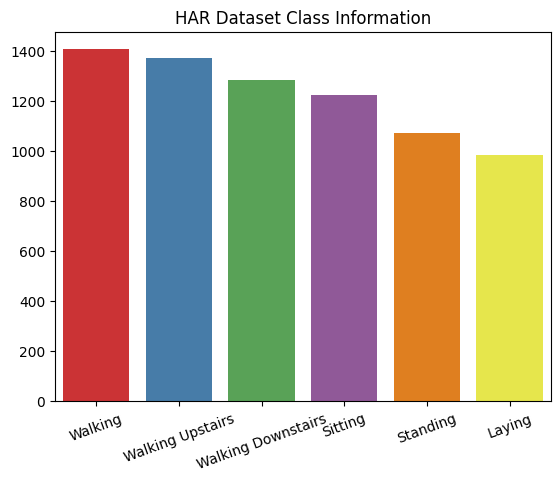

In [12]:
"""y 데이터 EDA"""

sns.barplot(x=['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying'], 
            y=pd.Series(train_label).value_counts().values, palette='Set1');
plt.xticks(rotation=20)
plt.title("HAR Dataset Class Information");

pd.DataFrame(train_label).value_counts();

### 3-2. 데이터 전처리

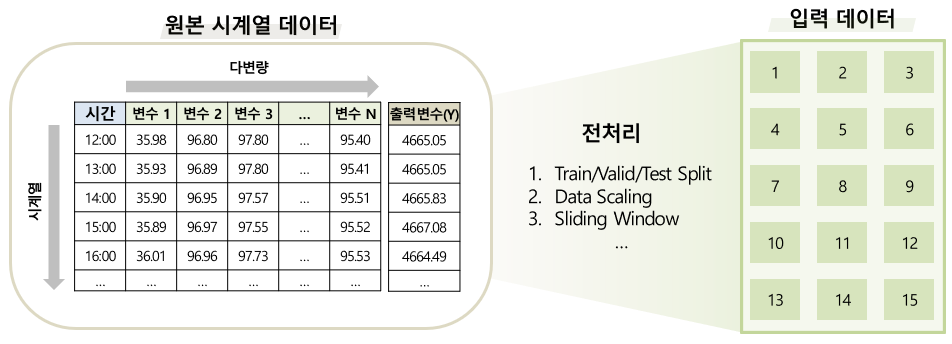

In [2]:
Image('./images/preprocess.PNG')

#### Train / Valid / Test Split

In [25]:
len_train = int(len(train_data) * 0.8)  # 기존 학습 데이터 중 80%는 학습용, 그 외는 검증용으로 활용

"""Note: 시계열 데이터는 random split을 하지 않음! 순차적으로 train/valid/test를 나누어주는 것이 일반적."""
new_train_data = train_data[:len_train, : , :]
new_train_label = train_label[:len_train]

val_data = train_data[len_train:, : , :]
val_label = train_label[len_train:]

### 참고. Time Series Augmentation for Deep Learning
- Jittering: 시계열 데이터에 작은 noise를 추가하여 데이터 각 포인트에 임의의 변동(jitter)을 추가
    - noise 크기는 데이터의 scale과 분산을 고려하여 신중히 선택 필요
- Scaling: 시계열 데이터의 스케일을 변경(절대적인 값의 범위를 조금 변경)하는 기법으로, 값의 절대적 크기보다는 데이터의 패턴이나 추세를 학습하는 데 더 집중 가능
- 추가적인 기법은 [논문](https://arxiv.org/pdf/2002.12478.pdf) 참고

In [14]:
"""Augmentation"""
# timeseries augmentation은 한정적!

def TS_Jitter(X, sigma=0.001):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

def TS_Scaling(X, sigma=0.2):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

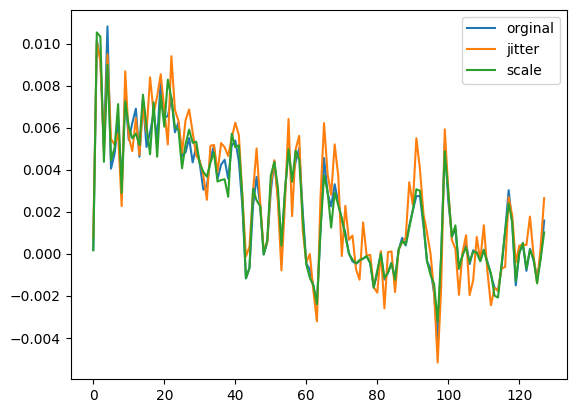

In [15]:
ts = new_train_data[0].transpose(1,0)
ts_jitter = TS_Jitter(ts)
ts_scale = TS_Scaling(ts)

plt.plot(ts[0], label='orginal')
plt.plot(ts_jitter[0], label='jitter')
plt.plot(ts_scale[0], label='scale')
plt.legend()
plt.show();

### 3-4. 데이터 로드 및 전처리 과정 함수화
- 앞선 모든 과정을 함수화 하여 표현

In [16]:
# 데이터셋과 관련한 하이퍼파라미터 정의
data_configs = {
    'data_dir':"./data/UCI HAR Dataset/",
    'jitter':False,    # 증강 기법 'jitter' 이용 여부
    'scale':False,     # 증강 기법 'scale' 이용 여부
    'aug_prob':.5,     # 50%의 확률로 데이터 augmentation 수행
    'train_ratio': .8, # 전체 train dataset 중 80%만 train, 20%는 valid로 사용
    'input_dim':9,     # 센서 (변수) 개수
    'num_classes':6,   # 분류해야 할 class의 개수
    'batch_size':64,
}
configs.update(data_configs)
print(configs)

{'device': 'cuda', 'seed': 0, 'data_dir': './data/UCI HAR Dataset/', 'jitter': False, 'scale': False, 'aug_prob': 0.5, 'train_ratio': 0.8, 'input_dim': 9, 'num_classes': 6, 'batch_size': 64}


In [17]:
class HAR_preprocess():
    def __init__(self, configs):
        self.configs = configs

        # load x data
        train_data = self.make_data(glob.glob(os.path.join(self.configs['data_dir'], 'train/Inertial Signals/*')))
        test_data = self.make_data(glob.glob(os.path.join(self.configs['data_dir'], 'test/Inertial Signals/*')))

        # load y data
        train_label = (pd.read_csv(os.path.join(self.configs['data_dir'], 'train/y_train.txt'), 
                                    header=None, sep=' ').values-1).squeeze()
        test_label = (pd.read_csv(os.path.join(self.configs['data_dir'], 'test/y_test.txt'), 
                                    header=None, sep=' ').values-1).squeeze()

        # split train/valid/test
        train_data, train_label, valid_data, valid_label = self.split_train_valid(train_data, 
                                                                                  train_label, 
                                                                                  self.configs['train_ratio'])

        self.trainset = {'X': train_data, 'y': train_label}
        self.validset = {'X': valid_data, 'y': valid_label}
        self.testset = {'X': test_data, 'y': test_label}

    @staticmethod
    def split_train_valid(x, y, train_ratio:float=0.8):
        len_train = int(len(x)*train_ratio)

        train_data, train_label = x[:len_train,:,:], y[:len_train]
        valid_data, valid_label = x[len_train:,:,:], y[len_train:]

        return train_data, train_label, valid_data, valid_label

    def make_data(self, data_path):
        data = []
        for i in range(len(data_path)):
            data.append(self.read_data(data_path[i]))
        data = np.transpose(np.array(data), (1,2,0))
        return data
    
    @staticmethod
    def read_data(path_name):
        with open(path_name) as f:  # os.path.join(path, filename) 경로의 file을 f 라는 이름으로 open
            data = []
            for line in f:  # f 라는 이름의 txt 데이터를 line 별로 for문을 돌면서 읽기
                num = [float(l) for l in line.split()]  # f라는 이름의 file 내의 line을 for문을 돌며 float 형태로 변환
                data.append(num)  # 각 값을 data로 만들기 위해 list 안에 담기
        data = np.array(data)     # list 형태의 데이터를 np.array 형태로 바꾸어주기
        return data
    
    def jitter(self, x, sigma=0.001):
        noise = np.random.normal(loc=0, scale=sigma, size=x.shape)
        return x + noise

    def scaling(self, x, sigma=0.2):
        scaling_factor = np.random.normal(loc=1.0, scale=sigma, size=(1, x.shape[1])) # shape=(1,3)
        noise = np.matmul(np.ones((x.shape[0],1)), scaling_factor)
        return x*noise

In [18]:
get_data = HAR_preprocess(configs)
print(f" 학습용 입력 데이터 형태: {get_data.trainset['X'].shape}, \n 학습용 출력 데이터 형태: {get_data.trainset['y'].shape}")

 학습용 입력 데이터 형태: (5881, 128, 9), 
 학습용 출력 데이터 형태: (5881,)


### 3-5. Custom Dataset 만들기

#### (참고) PyTorch Custom Dataset
- torch.utils.data.Dataset을 상속받아 직접 Custom Dataset 만들기

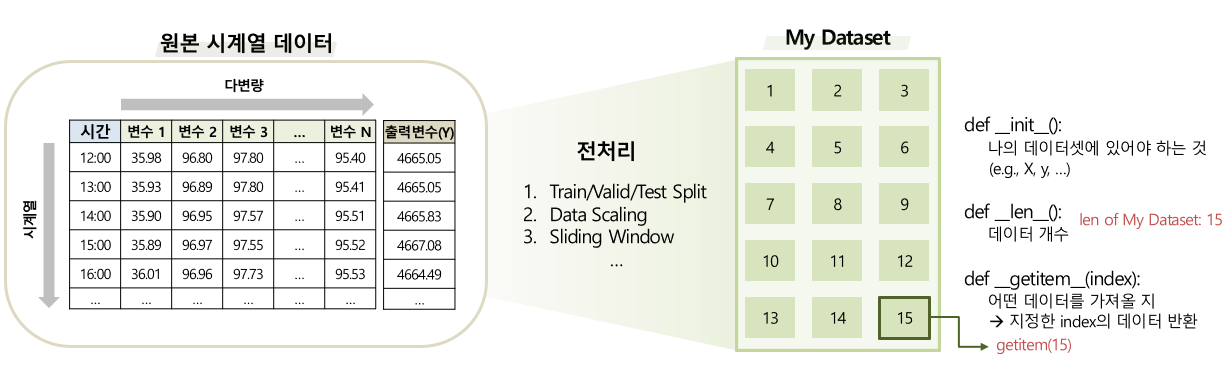

In [3]:
Image('./images/custom_dataset.PNG')

In [27]:
class CustomDataset(Dataset):
  def __init__(self):
    """객체가 생성될 때 초기화를 위해 호출하는 특수 메서드.
        데이터셋 구축을 위해 필요한 초기 설정을 수행하는 부분. (데이터 불러오기, 전처리 등)"""
    self.X = np.random.rand(5, 3)
    self.Y = np.random.randint(1, 5, (5,))

  def __len__(self):
    """데이터셋의 길이. 총 샘플의 수를 반환.
        len을 통해서 getitem의 idx 범위가 결정"""
    return len(self.X)

  def __getitem__(self, idx): 
    """인덱스(idx)를 입력받아, 이에 대응되는 데이터를 return.
        데이터를 로드하고 (필요 시) 전처리 후 반환 필요"""
    return {'X': torch.tensor(self.X[idx]).float(),
            'Y': torch.tensor(self.Y[idx]).long()}

In [28]:
mydataset = CustomDataset()
print("데이터셋 총 샘플 수 확인: ", mydataset.__len__())
print("데이터셋 0번째 샘플 가져오기: ", mydataset.__getitem__(0))
print("데이터셋 0번째 X 샘플 가져오기: ", mydataset.__getitem__(0)['X'])

데이터셋 총 샘플 수 확인:  5
데이터셋 0번째 샘플 가져오기:  {'X': tensor([0.4884, 0.6147, 0.8396]), 'Y': tensor(4)}
데이터셋 0번째 X 샘플 가져오기:  tensor([0.4884, 0.6147, 0.8396])


In [46]:
# HARDataset
class HARDataset(Dataset):
    def __init__(self, configs, mode:str):
        self.configs = configs
        self.get_data = HAR_preprocess(self.configs)

        if mode == "train":
            self.X, self.y = torch.Tensor(self.get_data.trainset['X']), torch.Tensor(self.get_data.trainset['y'])
        elif mode == "valid":
            self.X, self.y = torch.Tensor(self.get_data.validset['X']), torch.Tensor(self.get_data.validset['y'])
        elif mode == "test":
            self.X, self.y = torch.Tensor(self.get_data.testset['X']), torch.Tensor(self.get_data.testset['y'])
        else:
            raise ValueError("'mode' shoud be one of ['train', 'valid', 'test]")

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        # Transformation
        rand_prob = np.random.uniform()
        if self.configs['jitter'] and rand_prob > self.configs['aug_prob']:
            X = self.get_data.jitter(X)
        if self.configs['scale'] and rand_prob > self.configs['aug_prob']:
            X = self.get_data.scaling(X)

        return {'X':X.float(), 'y':y}
    
    @property
    def input_dim(self):
        # X의 변수 개수 (차원)을 반환
        return self.X.shape[-1]

- 참고:
    - @property 데코레이터는 클래스 내의 함수(method)를 마치 속성(attribute)처럼 사용할 수 있도록 해주는 기능
    - method 호출 시 괄호를 생략하고 마치 속성에 접근하는 것처럼 사용 가능한 장점

In [25]:
print('Train 데이터 수', HARDataset(configs, mode="train").X.size(0))
print('Valid 데이터 수', HARDataset(configs, mode="valid").X.size(0))
print('Test 데이터 수', HARDataset(configs, mode="test").X.size(0))

Train 데이터 수 5881
Valid 데이터 수 1471
Test 데이터 수 2947


### 3-6. DataLoader 정의

In [44]:
def get_dataloader(configs):
    trainset = HARDataset(configs, mode="train")
    validset = HARDataset(configs, mode="valid")
    testset = HARDataset(configs, mode="test")

    trainloader = DataLoader(trainset, batch_size=configs['batch_size'], shuffle=True, drop_last=False)
    validloader = DataLoader(validset, batch_size=configs['batch_size'], shuffle=False, drop_last=False)
    testloader = DataLoader(testset, batch_size=configs['batch_size'], shuffle=False, drop_last=False)

    return trainloader, validloader, testloader

In [47]:
trainloader, validloader, testloader = get_dataloader(configs)

-------

## 4. 모델 정의
- RNN, LSTM, GRU with(out) Attention

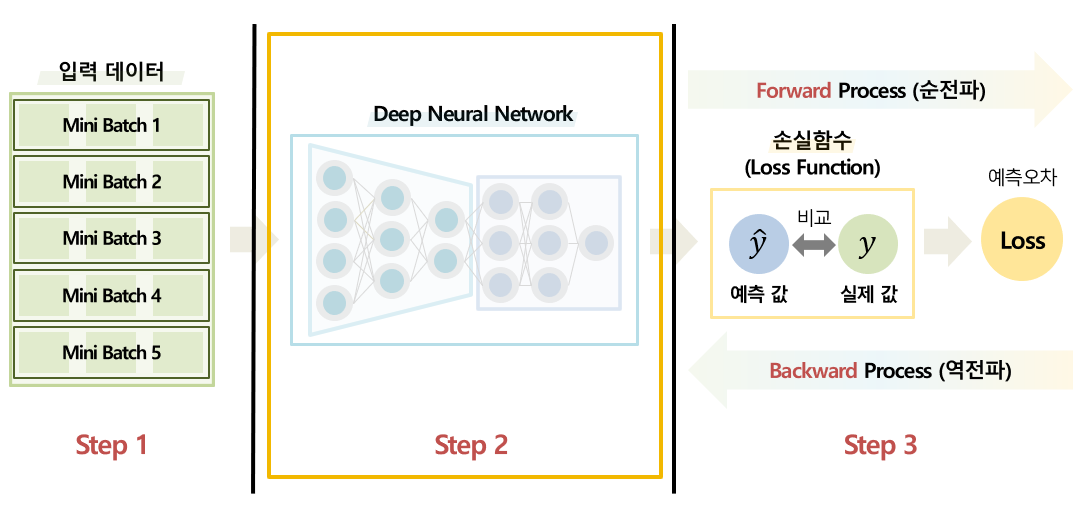

In [35]:
Image('./images/model.PNG')

### RNN

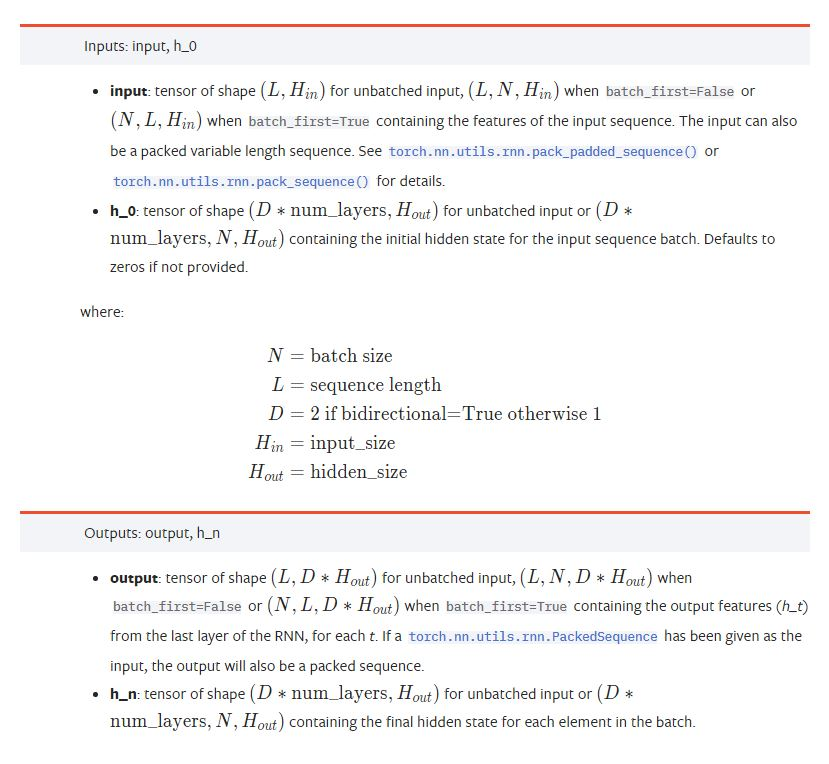

In [26]:
Image('./images/RNN.JPG')

Input: ($N$, $L$, $H_{in}$)  
- $N$: 데이터 샘플의 개수 -> 모델링 시에는 Batch size를 의미. 우리는 64개의 샘플을 Batch size로 사전 정의.
- $L$: 한 샘플 내의 values 개수, 시계열 데이터에서는 샘플 당 timestep (시간 길이)를 의미. 우리는 128로 고정.
- $H_{in}$: 다변량 시계열 데이터의 경우, 데이터 변수의 개수가 됨. 우리는 9개 (센서의 개수).
    - Cf. CNN1D에서는 이것이 Channel 수가 됨 (C)  
    
Output: ($N$, $L$, $D*H_{out}$)
- $N$: 데이터 샘플의 개수
- $L$: 한 샘플 내의 values 개수
- $D*H_{out}$: $H_{out}$은 우리가 사전에 지정할 모델의 hidden dimension을 의미. 
    - $D$는 RNN 모델의 경우 양방향 모델일 시 2, 단방향 모델일 시에는 1로 고정됨

### 참고. Bidirectional RNN
- **Standard RNN** : 입력 데이터를 한 방향으로 처리 (과거에서 미래 방향으로)
    - 하나의 RNN만을 사용하여 이전 시점 정보를 현재 시점으로 전달
- **Bidirectional RNN** : 입력 데이터를 두 방향으로 처리 (과거에서 미래, 미래에서 과거 방향)
    - 두 개의 RNN을 사용. 하나는 정방향, 다른 하나는 역방향으로 데이터를 처리
    - [장점] 시계열 데이터의 앞뒤 정보를 모두 동시에 반영하기에 보다 정확한 예측 및 처리가 가능
    - [단점] 두 개의 RNN을 병렬로 사용하므로 계산량 증가

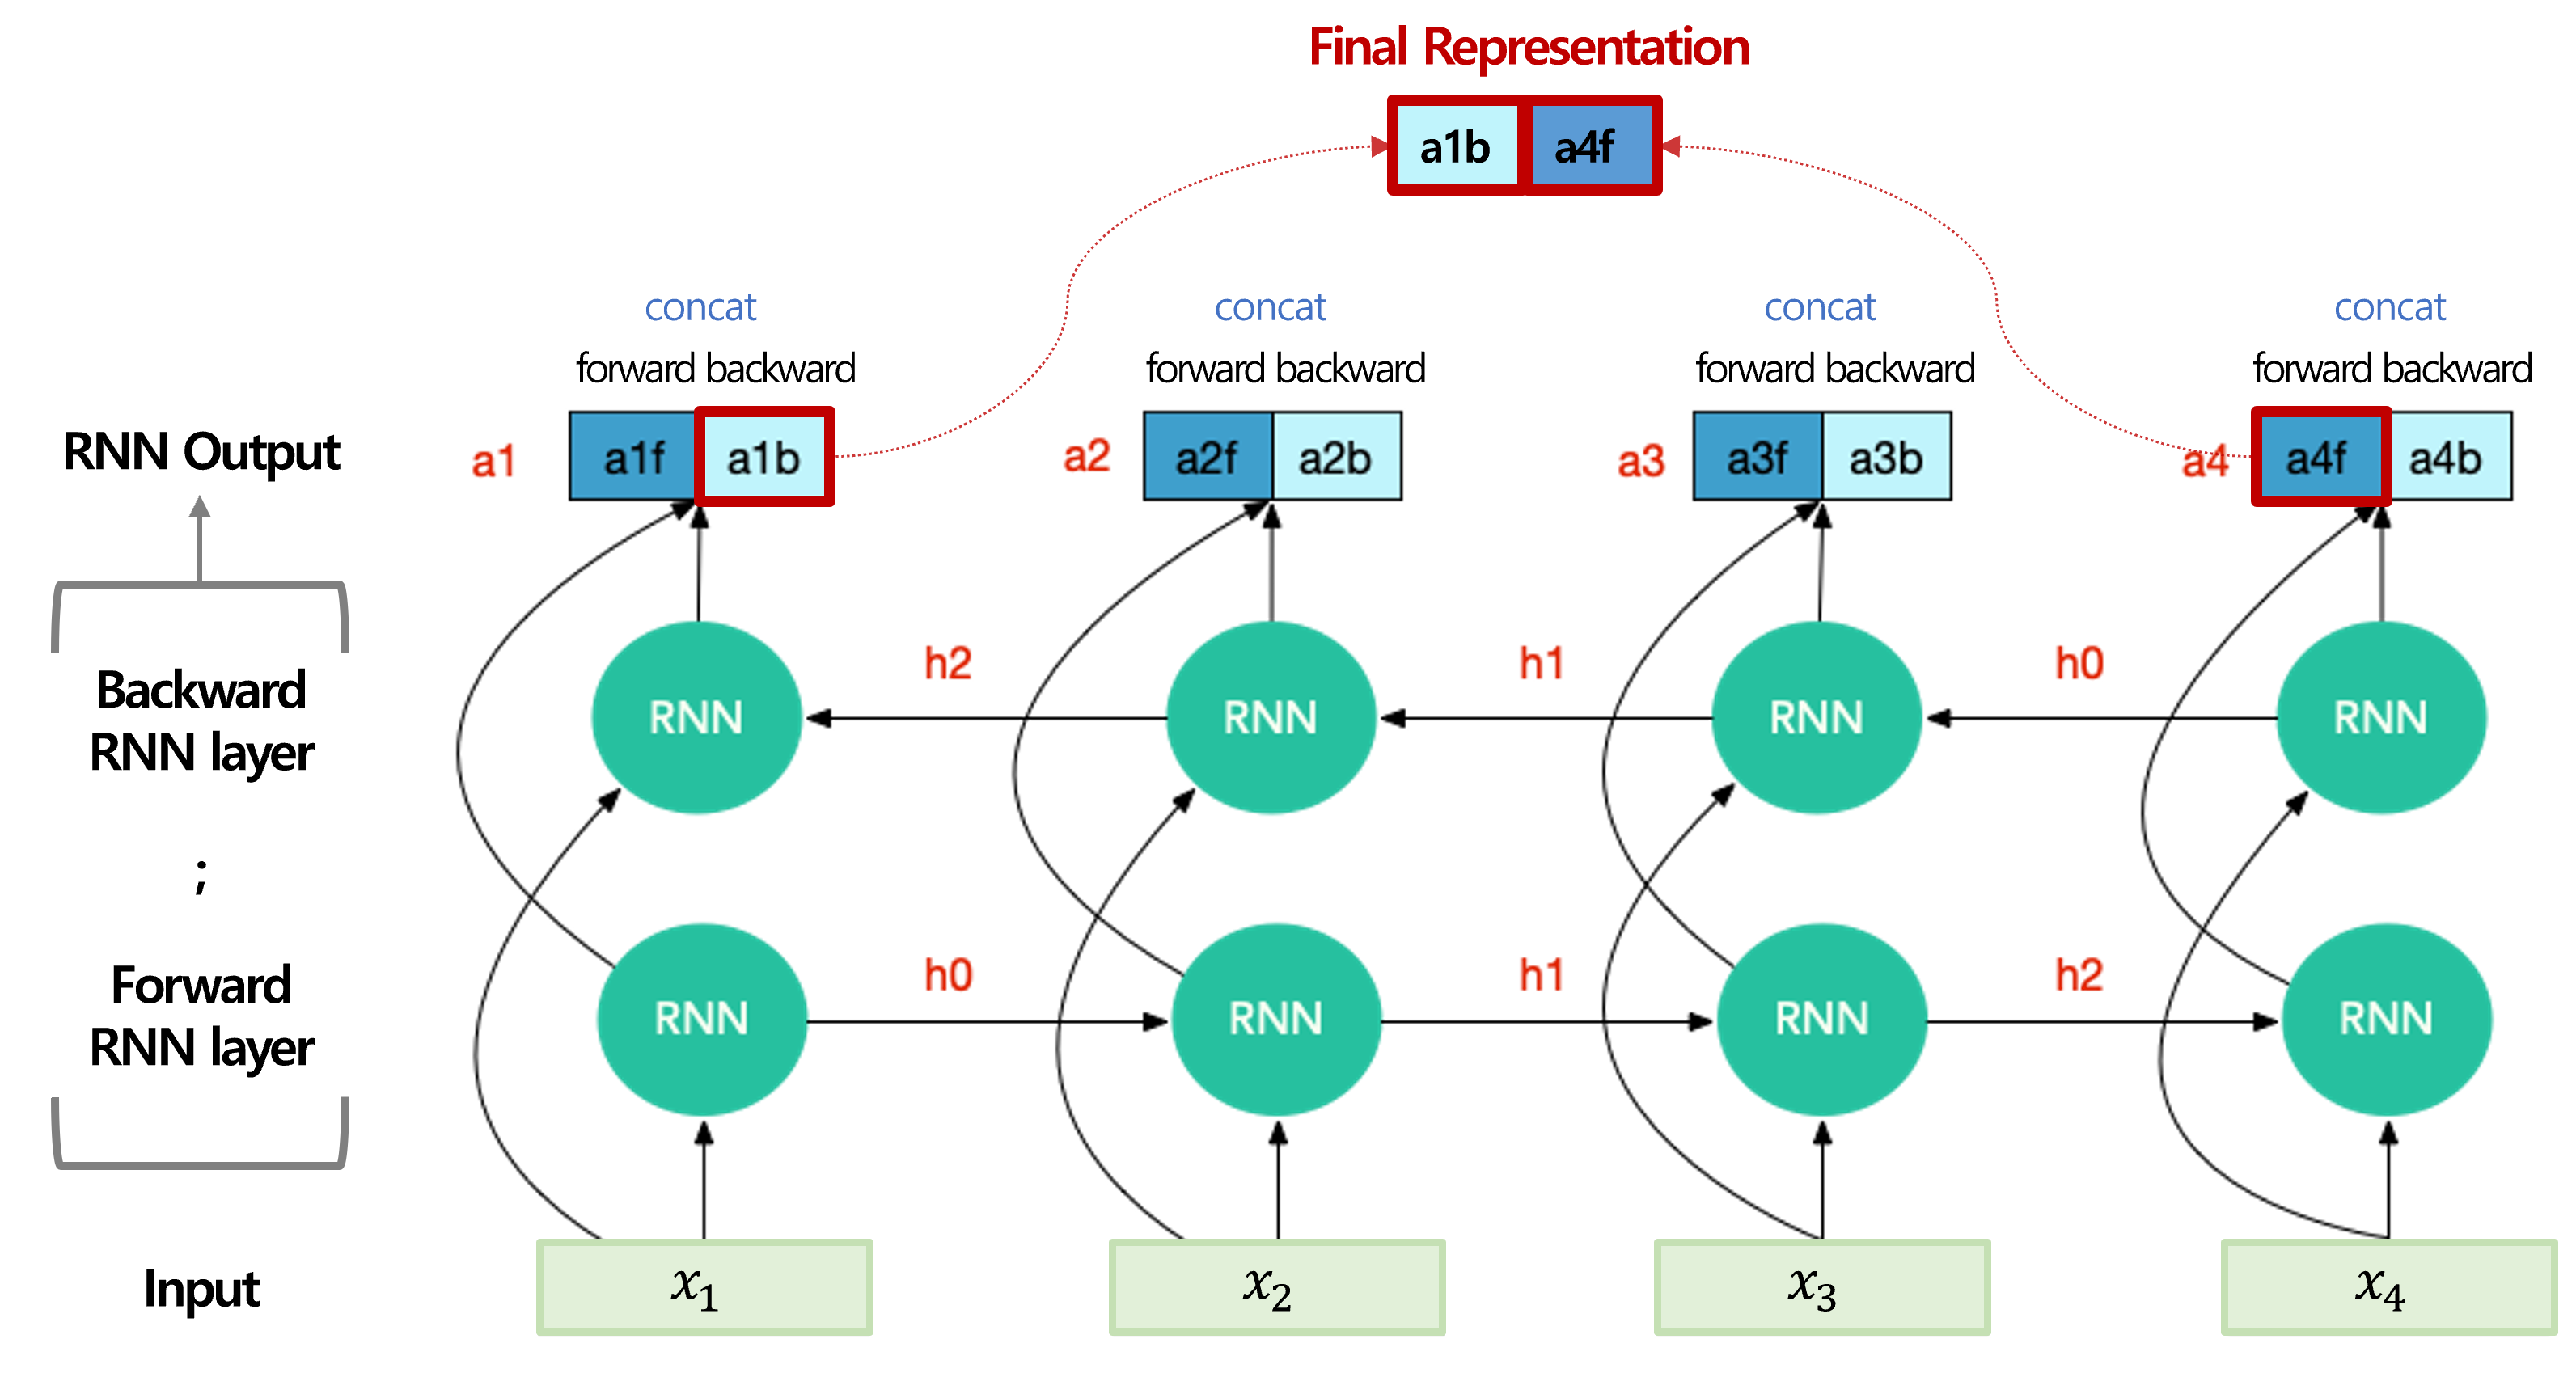

In [27]:
Image('./images/BiRNN.PNG')

### LSTM

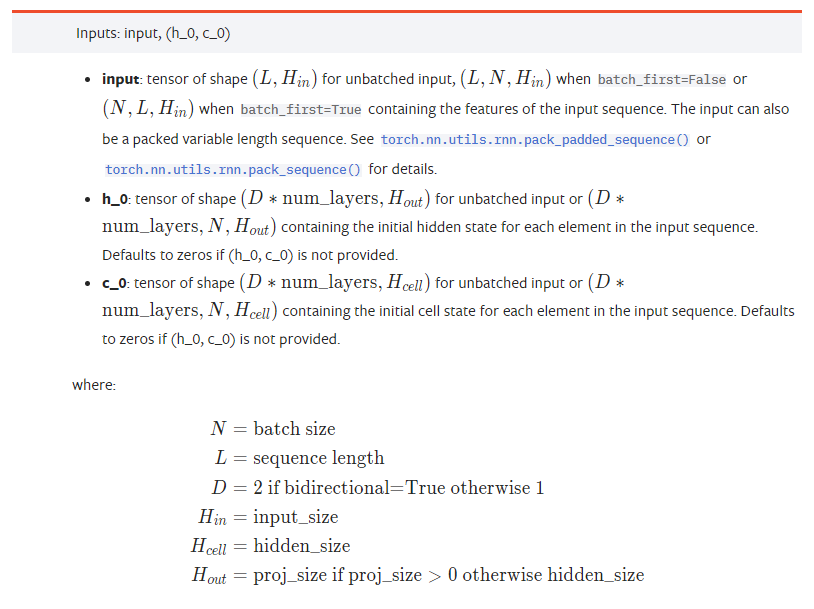

In [36]:
Image('./images/lstm_input.PNG')

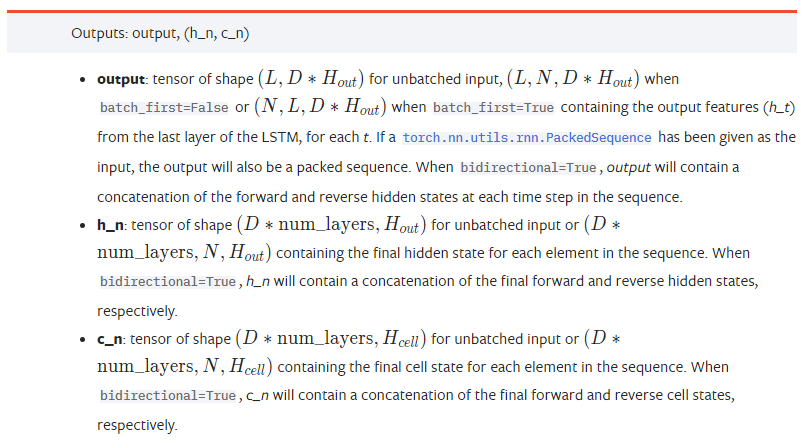

In [37]:
Image('./images/lstm_out.PNG')

- LSTM의 경우 RNN과 GRU와 달리 initial cell state도 함께 정의해야 하며, output states도 hidden states뿐 아니라 cell states까지 함께 반환됨에 주의

In [41]:
model_configs = {
    'rnn_type': 'RNN',       # 'RNN', 'LSTM', 'GRU' 중 하나 선택 (str)
    'is_attention':True,     # attention을 활용할 지 하지 않을 지 선택 (bool)
    'return_attention_weight':True, # attention 가중치를 반환할 지 하지 않을 지

    'hidden_size': 64,       # RNN 레이어가 가지는 은닉 노드 수 (int)
    'num_layers': 2,         # RNN 레이어를 몇 개 쌓을지 (int)
    'bidirectional': True,   # 단방향/양방향 여부 (bool: True or False)
    'dropout_rate': .1,      # dropout
    'num_classes':6          # 분류해야 할 class 개수
}

configs.update(model_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/UCI HAR Dataset/',
 'jitter': False,
 'scale': False,
 'aug_prob': 0.5,
 'train_ratio': 0.8,
 'input_dim': 9,
 'num_classes': 6,
 'batch_size': 64,
 'rnn_type': 'RNN',
 'is_attention': True,
 'return_attention_weight': True,
 'hidden_size': 64,
 'num_layers': 2,
 'bidirectional': True,
 'dropout_rate': 0.1}

In [93]:
class Model(nn.Module):
    def __init__(self, configs, input_dim):
        super(Model, self).__init__()

        self.configs = configs
        self.input_dim = input_dim
        self.num_classes = configs['num_classes']      # 6
        self.hidden_size = configs['hidden_size']      # 64
        self.num_layers = configs['num_layers']        # 1
        self.bidirectional = configs['bidirectional']  # True
        self.dropout_rate = configs['dropout_rate']

        """모델이 정의되는 방식
        self.rnn = nn.RNN(
            input_size = configs['input_dim'],
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True,
            bidirectional = self.bidirectional,
            dropout=self.dropout_rate
        )
        """
        self.rnn_type = configs['rnn_type']
        rnn_type_list = ['RNN', 'LSTM', 'GRU']
        assert self.rnn_type in rnn_type_list  # RNN type model이 RNN, LSTM, GRU 중 하나여야 함

        self.rnn_model = getattr(nn, self.rnn_type)(     # getattr(class, "name")
            input_size = self.input_dim, 
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True,
            bidirectional = self.bidirectional,
            dropout = self.dropout_rate
        )

        self.classifier = nn.Linear(in_features=self.hidden_size * 2 if self.bidirectional else self.hidden_size, 
                                    out_features=self.num_classes)
        
        # scaled dot product attention!
        self.is_attention = configs['is_attention']
        self.return_attention_weight = configs['return_attention_weight']
        if self.is_attention:
            hidden_size = self.hidden_size * 2 if self.bidirectional else self.hidden_size
            self.scale = 1. / np.sqrt(hidden_size)  # hidden_size 증가에 따라 QK 내적 값이 커져 softmax 출력 값의 분포가 편향되는 것을 방지하기 위함
            self.query_projection = nn.Sequential(
                            nn.Linear(in_features=hidden_size, out_features=hidden_size),
                            nn.Tanh()
                            )
            self.projection = nn.Sequential(
                            nn.Linear(in_features=hidden_size*2, out_features=hidden_size),
                            nn.Tanh()
                            )
            
    def attention(self, query, keys, values):
        """
        Query : RNN-based Model의 마지막 timestep에 대한 hidden state
            - [batch_size, hidden_size]
        Keys : RNN-based Model의 모든 timestep에 대한 hidden state를 쌓아올린 matrix
            - [batch_size, time_steps, hidden_size]
        Values : Keys와 동일
            - [batch_size, time_steps, hidden_size]
        """
        # query projection
        query = self.query_projection(query)

        # calcuate alignmnet scores
        attention_scores = torch.bmm(keys, query.unsqueeze(2))

        # Apply softmax to obtain attention weights (scaing)
        attention_weights = torch.softmax(attention_scores.mul_(self.scale), dim=1)

        # Compute context vector
        context_vector = torch.sum(attention_weights * values, dim=1)

        # Projection
        context_vector = self.projection(torch.cat([query, context_vector], dim=1))

        return context_vector, attention_weights.squeeze()
        
    def forward(self, x):
        # Initial hidden state 초기화
        num_direction = self.num_layers*2 if self.bidirectional else self.num_layers
        h0 = torch.zeros(num_direction, x.size(0), self.hidden_size, device=x.device)

        if self.rnn_type == 'LSTM':
            # lstm의 경우 initial cell state 초기화
            c0 = torch.zeros(num_direction, x.size(0), self.hidden_size, device=x.device)
        
        # 시계열 데이터의 특징 추출
            # out = 모든 timestep에 대한 hidden state 값 (Batch size, Sequence length, D*H_out)
            # last_hidden = 마지막 timestep에 대한 hidden state 값 (D*num_layers, Batch size, H_out)
        init_state = (h0, c0) if self.rnn_type == 'LSTM' else h0
        out, last_hidden = self.rnn_model(x, init_state)

        # 양방향 RNN인 경우: 마지막 layer의 단방향, 역방향 layer hidden state를 결합 (concatenate)
        # 단방향 RNN인 경우: 가장 마지막 timestep에 대한 hidden state 값 
        last_hidden = last_hidden[0] if self.rnn_type == "LSTM" else last_hidden  # (hidden states, cell states) 중 hidden states만 선택
        last_out = torch.cat((last_hidden[-2, :, :], last_hidden[-1, :, :]), dim=1) if self.bidirectional else out[:, -1, :]
        
        if self.is_attention:
            # Attention
            last_out, attention_weight = self.attention(query=last_out, keys=out, values=out)

        # 추출된 특징을 classifier에 넣고, class 분류 수행
        pred = self.classifier(last_out)
        
        return (pred, attention_weight) if self.return_attention_weight else pred

In [89]:
model = Model(configs, trainloader.dataset.input_dim)
model

Model(
  (rnn_model): LSTM(9, 64, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (classifier): Linear(in_features=128, out_features=6, bias=True)
)

---------------

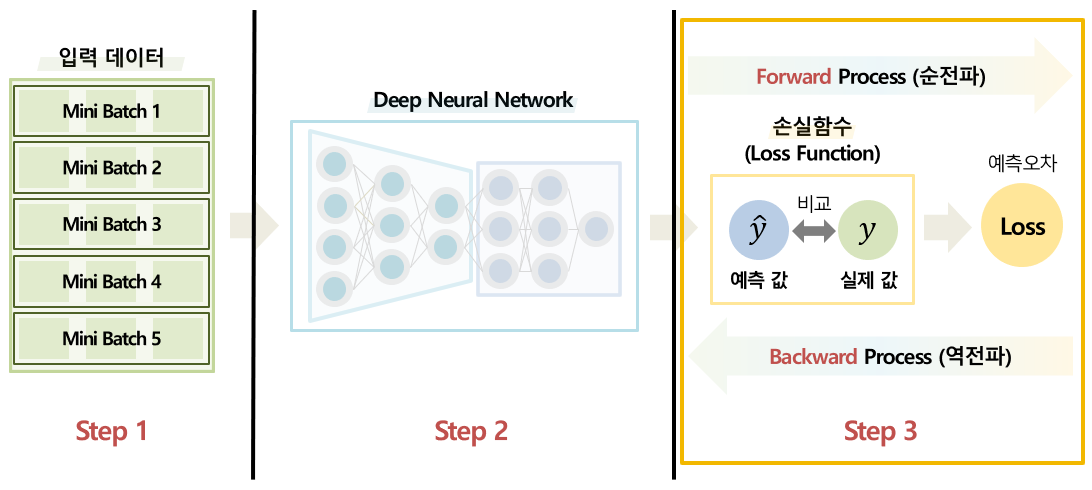

In [3]:
Image('./images/train.PNG')

## 5. Loss Function & Optimizer 정의

### 5-1. Loss Function 정의

In [31]:
criterion = nn.CrossEntropyLoss()

### 5-2. Optimizer 정의

In [49]:
opt_configs = {
    'optimizer':'adam',
    'lr':1e-4,
    'momentum':0.9,
    'weight_decay':0.0
}

configs.update(opt_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/UCI HAR Dataset/',
 'jitter': False,
 'scale': False,
 'aug_prob': 0.5,
 'train_ratio': 0.8,
 'input_dim': 9,
 'num_classes': 6,
 'batch_size': 64,
 'rnn_type': 'RNN',
 'is_attention': True,
 'return_attention_weight': True,
 'hidden_size': 64,
 'num_layers': 2,
 'bidirectional': True,
 'dropout_rate': 0.1,
 'optimizer': 'adam',
 'lr': 0.0001,
 'momentum': 0.9,
 'weight_decay': 0.0}

In [50]:
def get_optimizer(configs, model):
    if configs['optimizer'] == "sgd":
        optimizer = optim.SGD(params=model.parameters(), lr=configs['lr'],
                              momentum=configs['momentum'], weight_decay=configs['weight_decay'])

    elif configs['optimizer'] == "adam":
        optimizer = optim.Adam(params=model.parameters(), lr=configs['lr'], 
                                    betas=(configs['momentum'], 0.999), # (momentum, adaptive lr momentum)
                                    weight_decay=configs['weight_decay'])
    else:
        print("Invalid optimizer name, it should be one of ['sgd', 'adam']. Exiting...")
        exit()

    return optimizer

## 6. Forward & Backward

### 6-1. 학습에 필요한 하이퍼파라미터 정의

In [61]:
train_configs = {
    'num_epochs':50,
    'save_dir': './results/classification/',
    'visualize': True,
    'patience':10  # validation loss가 다시 떨어질 때까지 기다리는 epoch 횟수 (이를 넘으면 모델 저장 후 학습 조기종료)
}

configs.update(train_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'data_dir': './data/UCI HAR Dataset/',
 'jitter': False,
 'scale': False,
 'aug_prob': 0.5,
 'train_ratio': 0.8,
 'input_dim': 9,
 'num_classes': 6,
 'batch_size': 64,
 'rnn_type': 'RNN',
 'is_attention': True,
 'return_attention_weight': True,
 'hidden_size': 64,
 'num_layers': 2,
 'bidirectional': True,
 'dropout_rate': 0.1,
 'optimizer': 'adam',
 'lr': 0.0001,
 'momentum': 0.9,
 'weight_decay': 0.0,
 'num_epochs': 50,
 'save_dir': './results/classification/',
 'visualize': True,
 'patience': 10}

### 6-2. Train 과정 함수화

In [53]:
def train(device, model, trainloader, criterion, optimizer):
    model.train()
    num_iterations = len(trainloader)
    train_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실을 기록하기 위한 변수
                    'accuracy': torch.zeros(num_iterations)}   # 모델의 성능(accuracy)을 기록하기 위한 변수
    
    for i, batch in enumerate(trainloader):
        # X, y 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
        X, y = batch['X'].to(device), batch['y'].to(device).long()

        # forward
        logits = model(X)  # model에 입력 데이터 x를 넣으면 자동으로 forward 함수가 호출되어 prediction 값을 output으로 도출
        logits = logits[0] if len(logits)==2 else logits  # attention weights까지 반환하면 len(logits)는 2가 됨

        # Loss 계산!
        loss = criterion(logits, y)

        """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
        loss.backward()  # PyTorch 자동 미분

        """optimizer를 이용한 파라미터 업데이트"""
        optimizer.step()
        
        """Optimizer Gradient 초기화"""
        optimizer.zero_grad()

        # 모델 성능 계산!
        max_pred = torch.max(logits.detach(), dim=-1)[1] # 샘플 별 logit의 max 값들을 뽑기 -> [1]로 max 값들의 idx를 반환
                                                         # logit의 max 값은 모델이 해당 class로 예측했다는 의미
        accuracy = torch.eq(max_pred, y).sum().cpu().item() / len(y)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

        train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.
        train_history['accuracy'][i] = accuracy

    train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기 

    return train_result

### 6-3. Valid (Evaluate) 과정 함수화

In [54]:
def evaluate(device, model, validloader, criterion):
    model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

    num_iterations = len(validloader)
    valid_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실(loss)을 기록하기 위함
                    'accuracy': torch.zeros(num_iterations)}   # 모델의 성능(accuracy)을 기록하기 위함

    with torch.no_grad():  # 자동미분 연산 중지
        for i, batch in enumerate(validloader):
            X, y = batch['X'].to(device), batch['y'].to(device).long()
            logits = model(X)
            logits = logits[0] if len(logits)==2 else logits

            loss = criterion(logits, y)

            """loss를 backward 하지 않는 것에 주의"""

            # 모델 손실 및 성능 기록
            max_pred = torch.max(logits.detach(), dim=-1)[1]
            accuracy = torch.eq(max_pred, y).sum().cpu().item() / len(y)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

            valid_history['loss'][i] = loss.item()   # 모델 손실 저장
            valid_history['accuracy'][i] = accuracy  # 모델 성능 저장

    valid_result = {k: v.mean().item() for k, v in valid_history.items()}

    return valid_result

### 6-4. 모델 학습 추세 시각화 함수

In [55]:
def visualize_model_training(epoch_history):
    # Loss 추세 시각화
    sns.lineplot(x=range(1, len(epoch_history['train_loss'])+1), y=epoch_history['train_loss'], label="Train Loss")
    sns.lineplot(x=range(1, len(epoch_history['valid_loss'])+1), y=epoch_history['valid_loss'], label="Valid Loss")
    plt.title("Train vs Valid Loss Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

    # 성능(Accuracy) 추세 시각화
    sns.lineplot(x=range(1, len(epoch_history['train_acc'])+1), y=epoch_history['train_acc'], label="Train Accuracy")
    sns.lineplot(x=range(1, len(epoch_history['valid_acc'])+1), y=epoch_history['valid_acc'], label="Valid Accuracy")
    plt.title("Train vs Valid Accuracy Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc="best")
    plt.show();

### 6-5. 학습이 완료된 모델의 파라미터를 저장하는 함수
- Save parameters of the trained model!
- earlystop!

In [74]:
class EarlyStopping:
    def __init__(self, patience:int=10, 
                verbose:bool=True, 
                delta:float=0.0, 
                save_dir:str="./best_model.pt"):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.save_dir = save_dir

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_min = 0.

    def __call__(self, val_acc, model):

        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation acc increased ({self.val_acc_min:.3f} --> {val_acc:.3f}).  Saving model ...')
        
        torch.save(model.state_dict(), os.path.join(self.save_dir, 'best_model.pt'))
        self.val_acc_min = val_acc

### 6-6. Test 과정 함수화

In [86]:
def test(device, save_dir, model, testloader):
    """test model 정의"""
    saved_model = torch.load(os.path.join(save_dir, 'best_model.pt')) # 학습이 완료된 모델의 파라미터 불러오기
    model.load_state_dict(saved_model)  # 훈련된 모델의 파라미터 값으로 설정

    """test 과정에서 pred, true를 모두 반환"""
    test_result = {'pred': [], 'true': []}

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X, y = batch['X'].to(device), batch['y'].to(device).long()
            
            logits = model(X) # B,2
            logits = logits[0] if len(logits)==2 else logits
            # 출력 값을 최대로 하는 인덱스(class 저장)
            pred = torch.argmax(logits, dim=1)

            test_result['pred'].extend(pred.squeeze().cpu().numpy())
            test_result['true'].extend(y.squeeze().cpu().numpy())

    return test_result

### 6-7. 모든 학습 프레임워크 함수화
- main 함수를 통해 학습을 수행

In [81]:
def main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    # Device 정의
    device = configs['device']
    
    # seed 정의
    set_seed(configs['seed'])

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    save_dir = os.path.join(configs['save_dir'], configs['rnn_type'], 'Attention') if configs['is_attention'] else os.path.join(configs['save_dir'], configs['rnn_type'])
    # 조기 종료 class 호출 (모델 저장을 위함)
    earlystopping = EarlyStopping(configs['patience'], save_dir=save_dir)
    # 모델 저장을 위한 경로 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    # 데이터 불러오기
    trainloader, validloader, testloader = get_dataloader(configs)
    
    # 모델 정의하기
    model = Model(configs, trainloader.dataset.input_dim)
    # GPU로 모델 및 loss function 전송 (CPU에서 계산하는 경우 연산량에 따라 시간이 오래 걸림)
    model, criterion = model.to(device), nn.CrossEntropyLoss().to(device)

    # optimizer 정의
    optimizer = get_optimizer(configs, model)  # 앞서 정의해두었던 함수 호출

    # training
    best_acc = 0.0              # 최종적으로 저장할 모델을 판단할 기준 설정 (초기화)
    best_epoch = 0.0            # 최종 모델이 몇 번째 epoch에서 도출되는지 저장 위함 (초기화)
    epoch_history = {'train_loss': [], 'train_acc': [],
                     'valid_loss': [], 'valid_acc': []}

    start = time.time()

    """Step 2: 학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):  

        print('-'*15, f'Epoch: {epoch}', '-'*15)

        train_result = train(device, model, trainloader, criterion, optimizer)     # 앞서 정의해두었던 함수 호출
        valid_result = evaluate(device, model, validloader, criterion)  # 앞서 정의해두었던 함수 호출

        print(f"Train Loss: {train_result['loss']:.2f} | Train Accuracy: {train_result['accuracy']:.2f}")
        print(f"Valid Loss: {valid_result['loss']:.2f} | Valid Accuracy: {valid_result['accuracy']:.2f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['train_loss'].append(train_result['loss'])
        epoch_history['train_acc'].append(train_result['accuracy'])
        epoch_history['valid_loss'].append(valid_result['loss'])
        epoch_history['valid_acc'].append(valid_result['accuracy'])

        """Step 4: 모델을 평가 (valid/eval) 하였을 때 성능 측면에서 가장 우수했던 모델을 저장"""
        earlystopping(valid_result['loss'], model)
        if valid_result['accuracy'] > best_acc:
            best_acc = valid_result['accuracy']  # best acc 값 업데이트
            best_epoch = epoch                   # best epoch 값 업데이트

        if earlystopping.early_stop:
            break

    # 최종적으로 선택된 모델에 대한 값 확인
    print(f"Best Valid Accuracy:{best_acc:.2f} | Best Epoch:{best_epoch}")

    # 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(epoch_history)

    """Step 5: 모델 최종 성능 평가"""
    test_result = test(device, save_dir, model, testloader)

    # 학습/테스트에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return test_result

Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/UCI HAR Dataset/', 'jitter': False, 'scale': False, 'aug_prob': 0.5, 'train_ratio': 0.8, 'input_dim': 9, 'num_classes': 6, 'batch_size': 64, 'rnn_type': 'RNN', 'is_attention': True, 'return_attention_weight': True, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/classification/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 1.55 | Train Accuracy: 0.39
Valid Loss: 1.38 | Valid Accuracy: 0.43
Validation acc increased (0.000 --> 1.384).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 1.16 | Train Accuracy: 0.49
Valid Loss: 1.24 | Valid Accuracy: 0.45
Validation acc increased (1.384 --> 1.239).  Saving model ...
--------------- Epoch: 3 ---------------
Train Loss: 1.02 | Train Accuracy: 0.55
Valid Loss: 1.09 | Vali

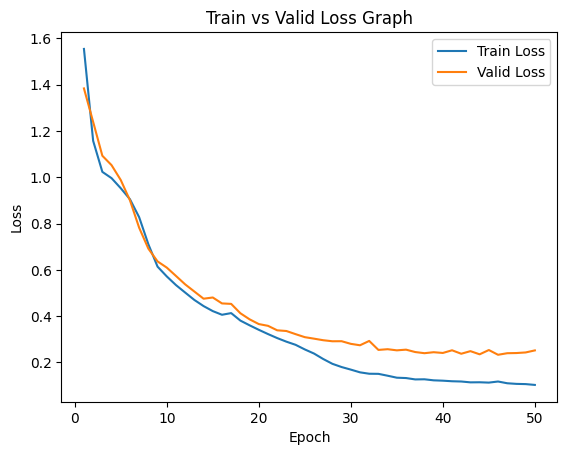

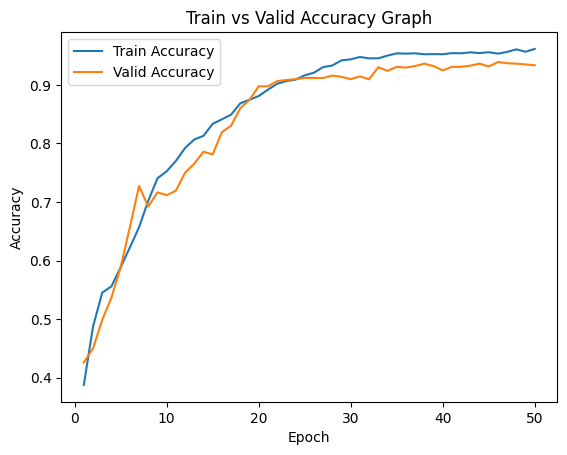

Total Training Time: 0.55 minutes


In [82]:
# 최종 main 함수 실행!!
test_result = main(configs)

----

### 6-8. Test 결과 확인
- 모델 성능 평가

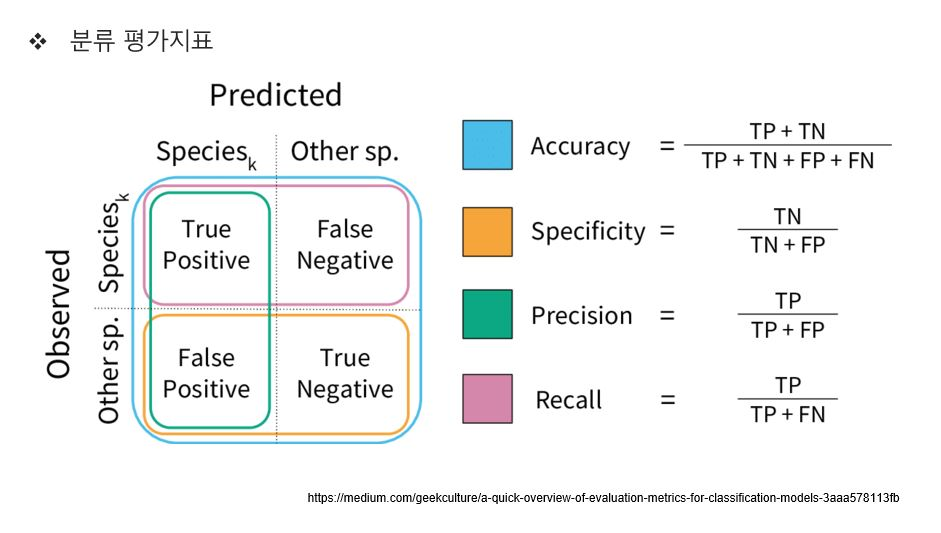

In [83]:
Image('./images/cf_matrix.JPG')

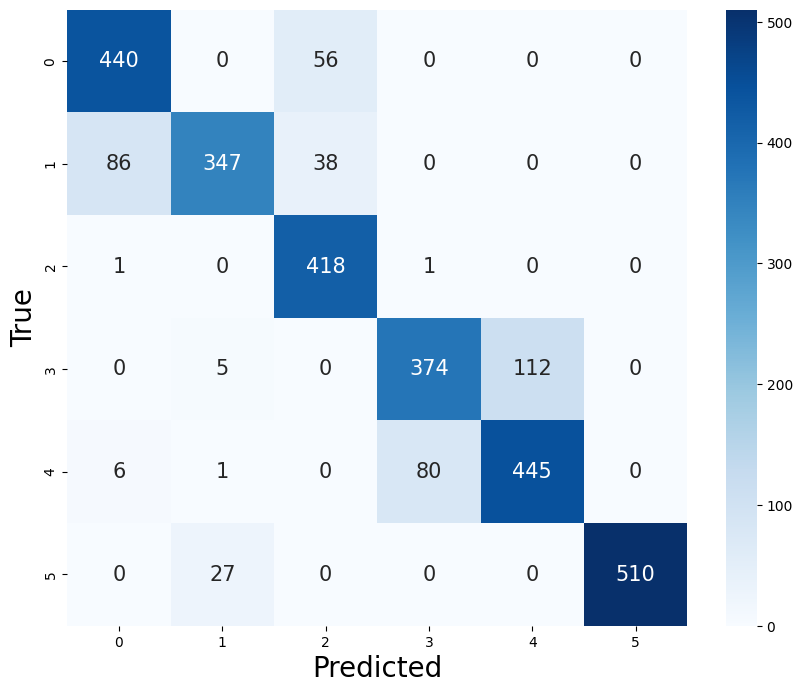

Test Accuracy   : 0.860
Test Recall     : 0.861
Test Precision  : 0.863
Test F1 Score   : 0.858


In [84]:
true, pred = test_result['true'], test_result['pred']

conf_mat = confusion_matrix(test_result['true'], test_result['pred'])

# confusion matrix 시각화
plt.figure(figsize=(10,8))
sns.heatmap(data=conf_mat, annot=True, fmt='d', annot_kws={'size':15}, cmap="Blues")
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

# 평가지표 계산
test_acc = accuracy_score(true, pred)
test_rec = recall_score(true, pred, average='macro')
test_prec = precision_score(true, pred, average='macro')
test_f1 = f1_score(true, pred, average='macro')

print('Test Accuracy   : {:.3f}'.format(test_acc))
print('Test Recall     : {:.3f}'.format(test_rec))
print('Test Precision  : {:.3f}'.format(test_prec))
print('Test F1 Score   : {:.3f}'.format(test_f1))

##### 질문. timestep 별이 아니라 입력 차원 (변수) 별 중요도를 구할 수는 없을까?
- RNN은 기본적으로 시계열 데이터의 시간적 의존성을 모델링하기 위해 설계되었습니다. 따라서 RNN의 구조적 특성상 attention은 특정 timestep의 출력(hidden state)이 예측에 얼마나 중요하게 영향을 미쳤는지 측정합니다.
- 입력 차원 (변수) 별 중요도를 확인하기 위해서는 아래의 방법을 이용/응용해보세요:
    - Transformer 모델의 self-attention을 이용
    - 각 변수 별로 별도의 RNN을 사용하고 결과를 결합
    - XAI 기법 활용 (e.g., SHAP)
    - 1D CNN 이용 (kernel 가중치 분석)
    - Gradient-based methods 이용 (e.g., GradCAM)

----

## 7. 비교 실험

### 7-1. 학습 수행

Experiment: Model_RNN, Attention_False
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/UCI HAR Dataset/', 'jitter': False, 'scale': False, 'aug_prob': 0.5, 'train_ratio': 0.8, 'input_dim': 9, 'num_classes': 6, 'batch_size': 64, 'rnn_type': 'RNN', 'is_attention': False, 'return_attention_weight': False, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/classification/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 1.68 | Train Accuracy: 0.32
Valid Loss: 1.49 | Valid Accuracy: 0.36
Validation acc increased (0.000 --> 1.494).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 1.30 | Train Accuracy: 0.44
Valid Loss: 1.32 | Valid Accuracy: 0.47
Validation acc increased (1.494 --> 1.316).  Saving model ...
--------------- Epoch: 3 ---------------
Train Loss: 1.13 | Tra

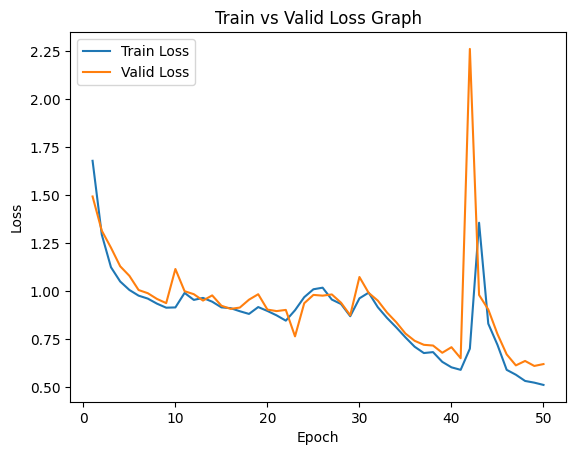

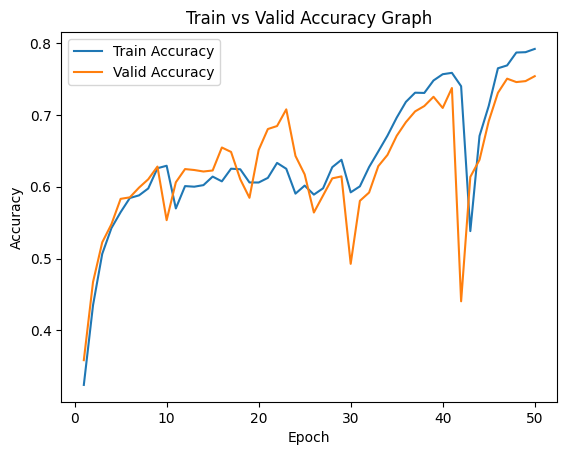

Total Training Time: 0.46 minutes
Experiment: Model_RNN, Attention_True
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/UCI HAR Dataset/', 'jitter': False, 'scale': False, 'aug_prob': 0.5, 'train_ratio': 0.8, 'input_dim': 9, 'num_classes': 6, 'batch_size': 64, 'rnn_type': 'RNN', 'is_attention': True, 'return_attention_weight': True, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/classification/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 1.55 | Train Accuracy: 0.39
Valid Loss: 1.38 | Valid Accuracy: 0.42
Validation acc increased (0.000 --> 1.384).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 1.16 | Train Accuracy: 0.49
Valid Loss: 1.23 | Valid Accuracy: 0.45
Validation acc increased (1.384 --> 1.234).  Saving model ...
--------------- Epoch: 3 -------

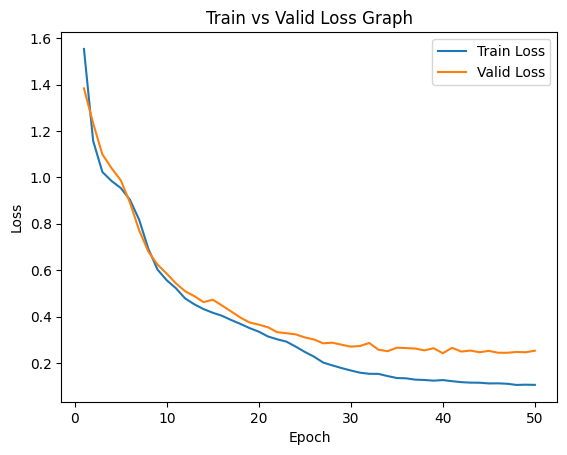

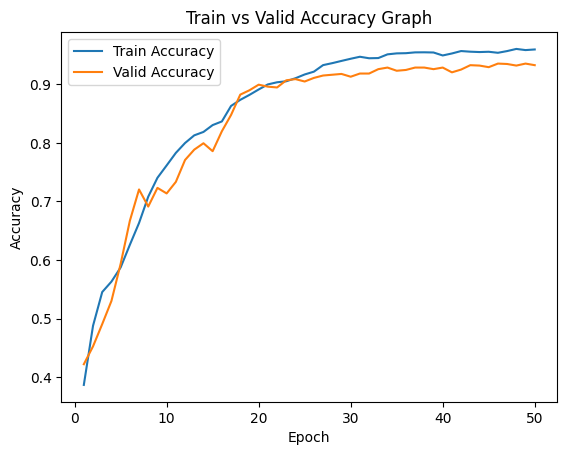

Total Training Time: 0.56 minutes
Experiment: Model_LSTM, Attention_False
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/UCI HAR Dataset/', 'jitter': False, 'scale': False, 'aug_prob': 0.5, 'train_ratio': 0.8, 'input_dim': 9, 'num_classes': 6, 'batch_size': 64, 'rnn_type': 'LSTM', 'is_attention': False, 'return_attention_weight': False, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/classification/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 1.76 | Train Accuracy: 0.34
Valid Loss: 1.72 | Valid Accuracy: 0.36
Validation acc increased (0.000 --> 1.718).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 1.48 | Train Accuracy: 0.37
Valid Loss: 1.38 | Valid Accuracy: 0.39
Validation acc increased (1.718 --> 1.385).  Saving model ...
--------------- Epoch: 3 --

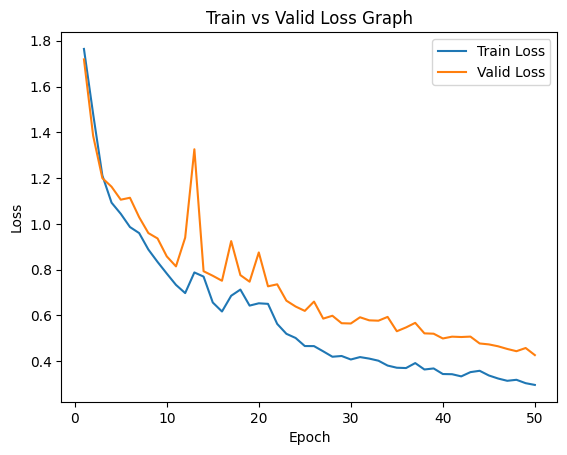

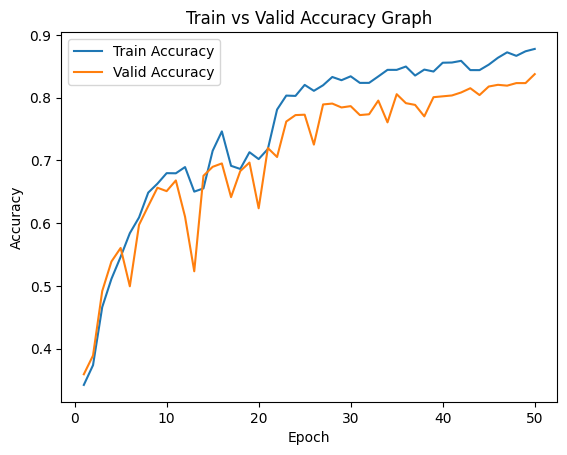

Total Training Time: 0.47 minutes
Experiment: Model_LSTM, Attention_True
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/UCI HAR Dataset/', 'jitter': False, 'scale': False, 'aug_prob': 0.5, 'train_ratio': 0.8, 'input_dim': 9, 'num_classes': 6, 'batch_size': 64, 'rnn_type': 'LSTM', 'is_attention': True, 'return_attention_weight': True, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/classification/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 1.73 | Train Accuracy: 0.27
Valid Loss: 1.54 | Valid Accuracy: 0.36
Validation acc increased (0.000 --> 1.541).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 1.33 | Train Accuracy: 0.40
Valid Loss: 1.33 | Valid Accuracy: 0.48
Validation acc increased (1.541 --> 1.332).  Saving model ...
--------------- Epoch: 3 -----

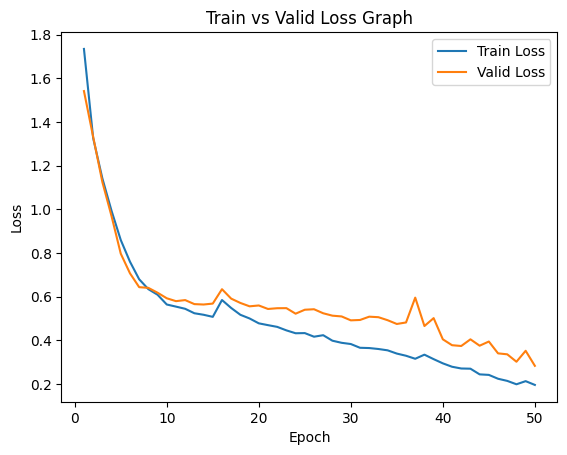

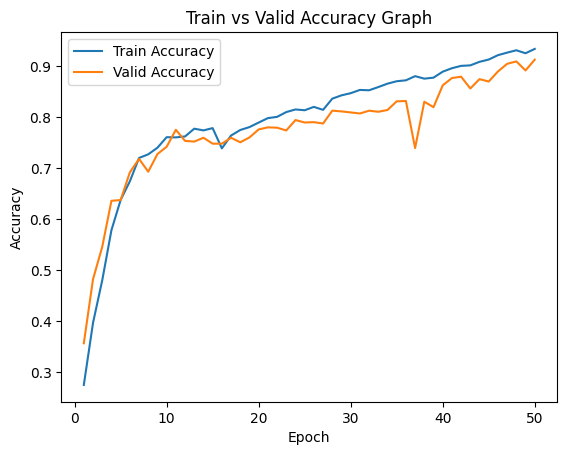

Total Training Time: 0.57 minutes
Experiment: Model_GRU, Attention_False
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/UCI HAR Dataset/', 'jitter': False, 'scale': False, 'aug_prob': 0.5, 'train_ratio': 0.8, 'input_dim': 9, 'num_classes': 6, 'batch_size': 64, 'rnn_type': 'GRU', 'is_attention': False, 'return_attention_weight': False, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/classification/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 1.71 | Train Accuracy: 0.40
Valid Loss: 1.61 | Valid Accuracy: 0.37
Validation acc increased (0.000 --> 1.606).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 1.41 | Train Accuracy: 0.42
Valid Loss: 1.36 | Valid Accuracy: 0.41
Validation acc increased (1.606 --> 1.357).  Saving model ...
--------------- Epoch: 3 ----

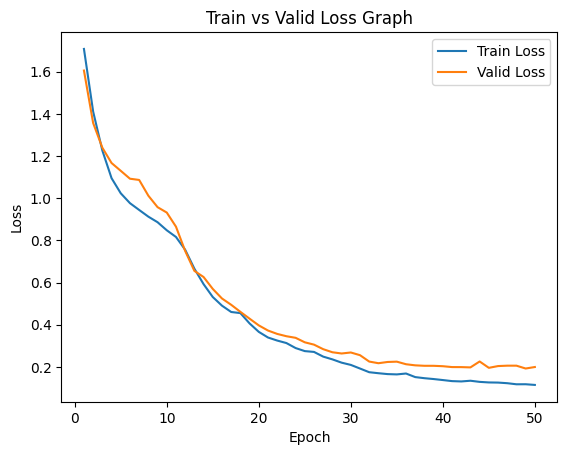

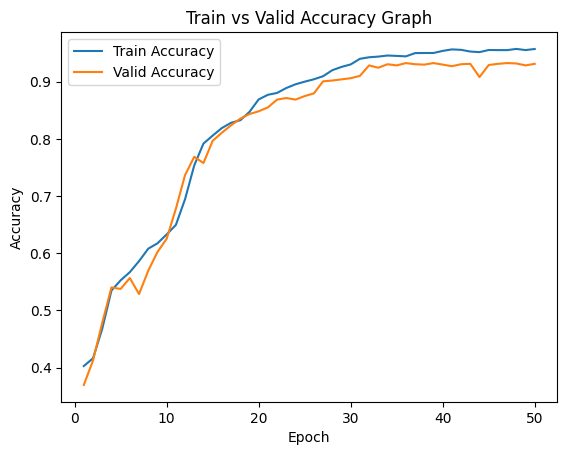

Total Training Time: 0.46 minutes
Experiment: Model_GRU, Attention_True
Configurations: 
 {'device': 'cuda', 'seed': 0, 'data_dir': './data/UCI HAR Dataset/', 'jitter': False, 'scale': False, 'aug_prob': 0.5, 'train_ratio': 0.8, 'input_dim': 9, 'num_classes': 6, 'batch_size': 64, 'rnn_type': 'GRU', 'is_attention': True, 'return_attention_weight': True, 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'optimizer': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/classification/', 'visualize': True, 'patience': 10}
--------------- Epoch: 1 ---------------
Train Loss: 1.60 | Train Accuracy: 0.38
Valid Loss: 1.37 | Valid Accuracy: 0.39
Validation acc increased (0.000 --> 1.370).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 1.21 | Train Accuracy: 0.47
Valid Loss: 1.21 | Valid Accuracy: 0.53
Validation acc increased (1.370 --> 1.211).  Saving model ...
--------------- Epoch: 3 -------

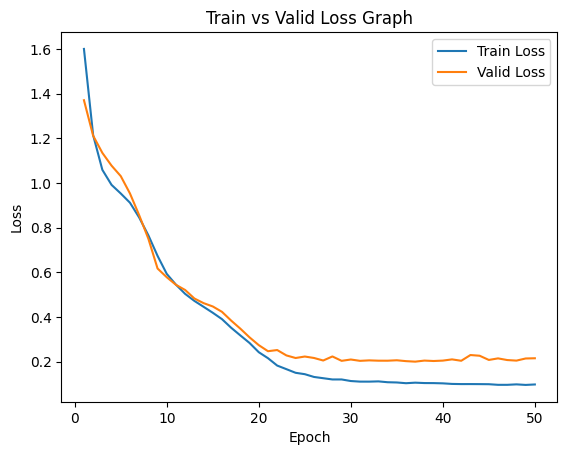

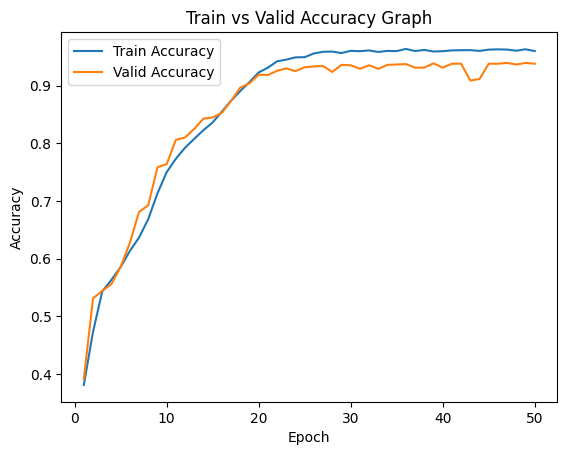

Total Training Time: 0.56 minutes


In [94]:
rnn_type_list = ['RNN', 'LSTM', 'GRU']
attention = [False, True]

for rnn_type in rnn_type_list:
    configs['rnn_type'] = rnn_type

    for is_attn in attention:
        configs['is_attention'] = is_attn
        configs['return_attention_weight'] = is_attn

        print(f"Experiment: Model_{configs['rnn_type']}, Attention_{configs['is_attention']}")

        main(configs)

### 7-2. Test

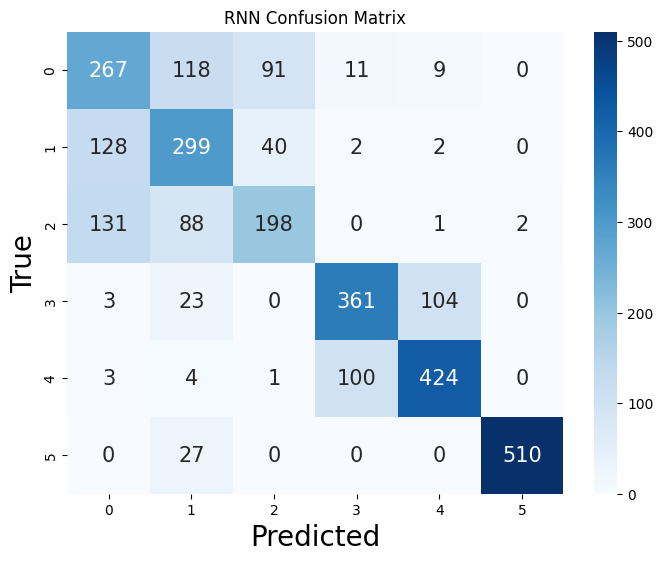

Test Accuracy   : 0.699
Test Recall     : 0.688
Test Precision  : 0.697
Test F1 Score   : 0.690


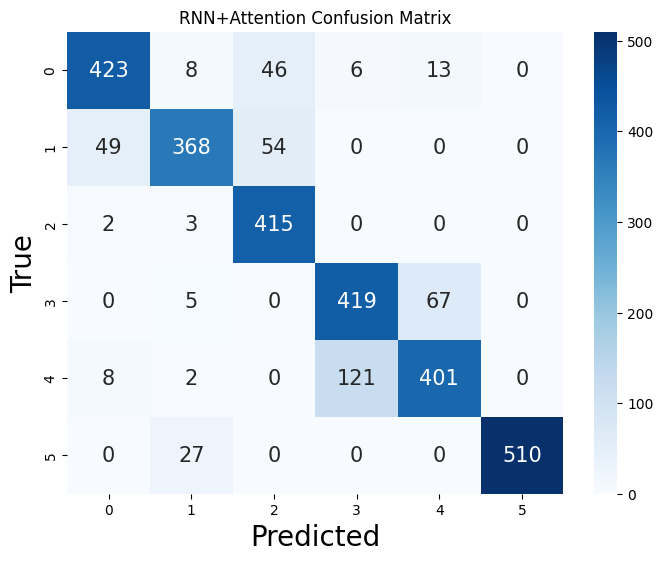

Test Accuracy   : 0.861
Test Recall     : 0.863
Test Precision  : 0.863
Test F1 Score   : 0.860


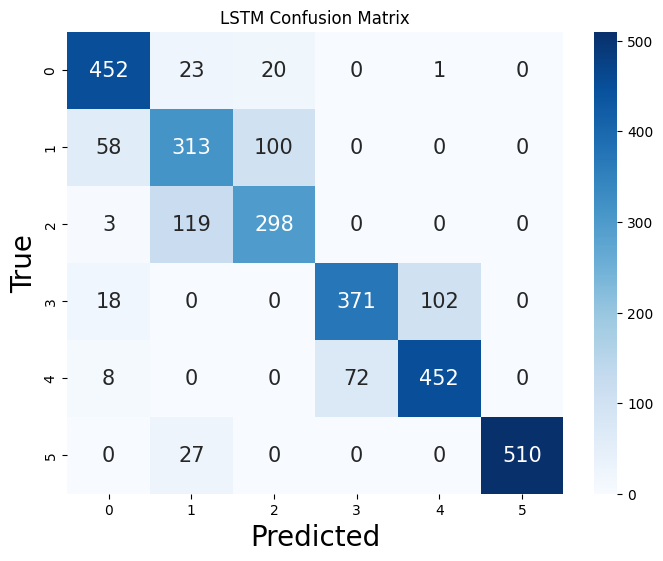

Test Accuracy   : 0.813
Test Recall     : 0.807
Test Precision  : 0.809
Test F1 Score   : 0.807


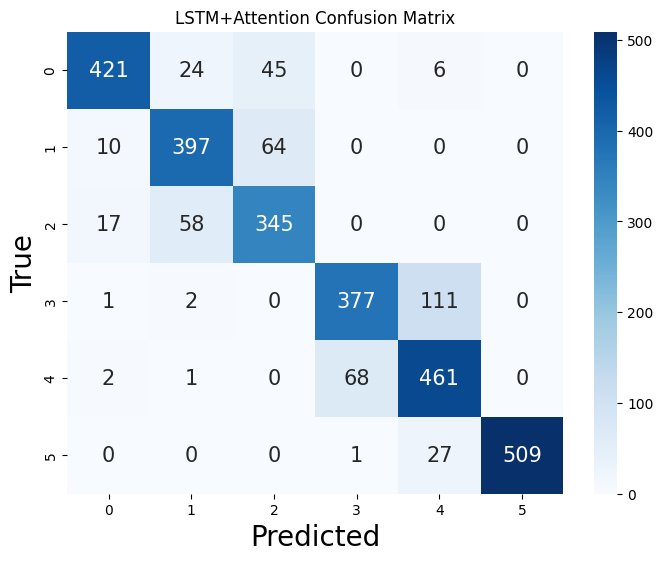

Test Accuracy   : 0.852
Test Recall     : 0.849
Test Precision  : 0.854
Test F1 Score   : 0.850


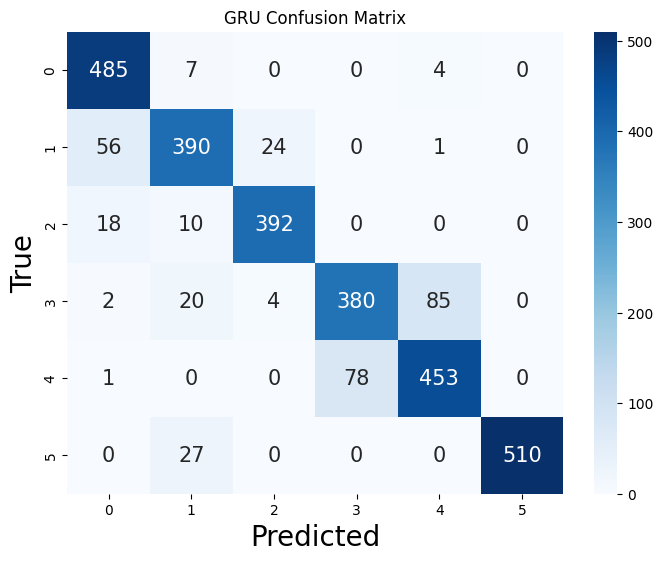

Test Accuracy   : 0.886
Test Recall     : 0.886
Test Precision  : 0.887
Test F1 Score   : 0.885


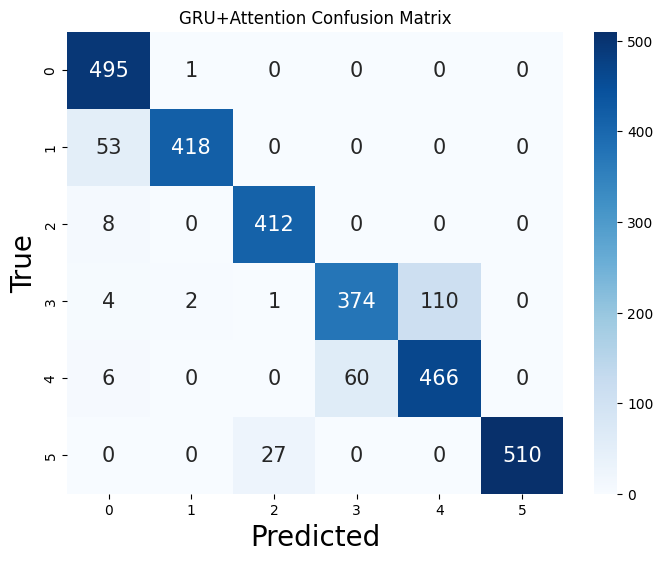

Test Accuracy   : 0.908
Test Recall     : 0.909
Test Precision  : 0.912
Test F1 Score   : 0.909


In [96]:
rnn_type_list = ['RNN', 'LSTM', 'GRU']
attention = [False, True]
save_dir_list, test_results = [], []

model = Model(configs, trainloader.dataset.input_dim)

for rnn_type in rnn_type_list:
    configs['rnn_type'] = rnn_type

    for is_attn in attention:
        configs['is_attention'] = is_attn
        configs['return_attention_weight'] = is_attn

        model = Model(configs, trainloader.dataset.input_dim).to(configs['device'])
        save_dir = os.path.join(configs['save_dir'], configs['rnn_type'], 'Attention') if configs['is_attention'] else os.path.join(configs['save_dir'], configs['rnn_type'])
        model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pt')))
        test_result = test(configs['device'], save_dir, model, testloader)

        true, pred = test_result['true'], test_result['pred']

        conf_mat = confusion_matrix(test_result['true'], test_result['pred'])

        # confusion matrix 시각화
        plt.figure(figsize=(8,6))
        sns.heatmap(data=conf_mat, annot=True, fmt='d', annot_kws={'size':15}, cmap="Blues")
        plt.xlabel('Predicted', size=20)
        plt.ylabel('True', size=20)
        backbone = configs['rnn_type']+"+Attention" if configs['is_attention'] else configs['rnn_type']
        plt.title(f"{backbone} Confusion Matrix")
        plt.show()

        # 평가지표 계산
        test_acc = accuracy_score(true, pred)
        test_rec = recall_score(true, pred, average='macro')
        test_prec = precision_score(true, pred, average='macro')
        test_f1 = f1_score(true, pred, average='macro')

        print('Test Accuracy   : {:.3f}'.format(test_acc))
        print('Test Recall     : {:.3f}'.format(test_rec))
        print('Test Precision  : {:.3f}'.format(test_prec))
        print('Test F1 Score   : {:.3f}'.format(test_f1))